# Phenotypes:
1. Hearing aids (f.3393)
2. Hearing difficulty/problems (f.2247)
3. Hearing difficulty/background noise (f.2257)

## Aim

Create a dataset of filtered individuals using the inclusion and exclusion criteria for diverse hearing related phenotyes to perform association analyses using the LMM.ipynb. 

## Location of files

In the shared folder is the original UKBB data
```
/gpfs/gibbs/pi/dewan/data/UKBiobank/phenotype_files/pleiotropy_R01/ukb42495_updatedJune2020
```

In my personal folder the filtered dataset

```
/home/dc2325/project/HI_UKBB
```

## Important phenotypic files

1. `200804_UKBB_HI_genotypeqc.csv` File containing all individuals that passed QC and hearing impairment variables
2. `200804_UKBB_HI_genotypeqc_excr.csv` File with applied exclusion criteria as indicated [here](https://docs.google.com/document/d/1cpxTzElpsEkwmBDjnMBHg2wW7CL1AcG_b0_0wE_k5rQ/edit). **Note**: this file excludes individuals with otosclerosis, Meniere's and other diseases, if you need to filter those particular phenotypes use file 1 instead.
3. `200811_UKBB_Tinnitus_plan1_2_3_f4803` File with filtered phenotypes for tinnitus plan 1,2 and 3 and imputed noise variables
4. `200814_UKBB_HI_genotypeqc_excr_impvars` Database with qc'ed individuals, exclusion criteria, noise imputed vars and tinnitus phenotypes

## Analysis plan

The phenotypes to be analyzed are the following:

1. Hearing aid user (f.3393)
"Do you use a hearing aid most of the time?"

2. Hearing difficulty/problems (f.2247)
"Do you have any difficulty with your hearing?"

3. Hearing difficulty/background noise (f.2257)
"Do you find it difficult to follow a conversation if there is background noise (such as TV, radio, children playing)?"

**Sex corresponds to f.22001 (genetic sex):**

- Male = 0
- Female = 1

**Noisy workplace and loud music exposure frequency: same as for Tinnitus**
                
1. Remove inconsistent individuals 
    - said 1,2 or 3 and in following visits said 0
    - said a higher exposure (e.g 3) and then a lower one (e.g 1 or 2) in following visits
2. Retain consistent individuals and use highest reported exposure

**The SRT trait needs to be inverse normalized**

**Covariates to be included in the analysis include:**

1. Age at time of test (calculated from f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0)
2. Sex f.22001
3. Volume left ear f.4270 and right ear f.4277 (The volume set by the participant for the measurement which you are using in the analysis ir our case the last time they took the test). For the analysis we use the average of the right and left ear since there is overlap in the volume distribution
4. Noisy workplace f.4825
5. Loud music exposure f.4836


## Load libraries and set working dir

In [ ]:
#Load libraries
library(plyr)
library(tidyverse)
library(pander)
library(ggpubr)
library(rapportools)
library(ggplot2)
#Get working directory
getwd()

In [2]:
#Set working directory
setwd('~/project/HI_UKBB/ukb42495_updatedJune2020')

In [3]:
# Clean workspace
rm(list=ls())

In [4]:
# Using only white british
#df.final.imp = read.csv('200814_UKBB_HI_genotypeqc_excr_impvars.csv')
# Using all whites
df.final.imp = read.csv('120120_UKBB_HI_expandedwhite_genotypeqc_excr.csv')

## Data summary and recode

In [5]:
dim(df.final.imp) #354347 only brits 1082 vars

[1] 396976   1074

In [6]:
table(df.final.imp$f.22001)


Female   Male 
216364 180612 

In [7]:
df.final.imp$sex <- revalue(df.final.imp$f.22001.0.0, c("Male" = '0', 'Female'='1' ))
table(df.final.imp$sex)
dim(df.final.imp)


     1      0 
216364 180612 

[1] 396976   1075

# f.3393 Hearing aid: filter out inconsistent cases

In [8]:
# Recode function:
recode<-function(df,column_name){
  new_names<-c()
  for (i in column_name){
    new_column_name<-paste0(i,"_recode")
    new_names<-c(new_names,new_column_name)
    df[,new_column_name] <- revalue(df[,i], c("No"= 0, 
                                            "Yes" =1,
                                            "Prefer not to answer"= NA))
  }
  return (list(df=df,new_column_names=new_names))
}

# columns needs to be recoded:
column_name<-c("f.3393.0.0","f.3393.1.0","f.3393.2.0","f.3393.3.0")

# get a new data.frame with recoded columns added:
df.final.imp<-recode(df=df.final.imp,column_name)$df

# get names of recoded columns:
new_column_names<-recode(df=df.final.imp,column_name)$new_column_names

# show recode summary:
for (i in new_column_names)
{cat(i,"summary:");print(table(df.final.imp[,i]));cat("\n")}

f.3393.0.0_recode summary:
     0      1 
227956  10927 

f.3393.1.0_recode summary:
    0     1 
15894   955 

f.3393.2.0_recode summary:
    0     1 
36535  3078 

f.3393.3.0_recode summary:
   0    1 
2415  206 



In [9]:
dim(df.final.imp)

[1] 396976   1079

## f. 3393 Get patterns for possible answers

In [10]:
# Extract subset of data only with the recode columns of tinnitus
data_sub <- df.final.imp %>%
  select("IID",all_of(new_column_names)) 

# Function to extract all the available answers for 4 visits
# and put them in one string as "0000", "111", "991", etc

f2<-function(x){
  visit<-''
  for (i in 2:5){ # do not take the first column (i.e. IID)
    if (!is.na(x[i]))
    {visit<-paste0(visit,x[i])}
  }
  if(is.null(visit)){visit=NA}
  else{visit=visit}
  return (visit)
}

# Apply the above function and remove NAs
data_sub$visit<-apply(data_sub, 1, f2)

names(table(data_sub$visit))

[1] ""     "0"    "00"   "000"  "0000" "0001" "001"  "0010" "0011" "01"  
[11] "010"  "0100" "011"  "0110" "0111" "1"    "10"   "100"  "101"  "11"  
[21] "110"  "1100" "111"  "1111"

In [11]:
table(data_sub$visit)
all_pattern<-unique(data_sub$visit)


            0     00    000   0000   0001    001   0010   0011     01    010 
137816 215691  25156   4296    231     13    267      6     10   1969     27 
  0100    011   0110   0111      1     10    100    101     11    110   1100 
     1    207      1      5  10188     82     13     18    824      6      1 
   111   1111 
   141      7 

## f.3393 Get all the consistent cases

In [12]:
all_no<-all_pattern[which(grepl("0",all_pattern) & !grepl("1",all_pattern))]
all_yes<-all_pattern[which(!grepl("0",all_pattern) & grepl("1",all_pattern))]
table(data_sub[data_sub$visit%in%union(all_no,all_yes),"visit"])


     0     00    000   0000      1     11    111   1111 
215691  25156   4296    231  10188    824    141      7 

In [13]:
consistent_1<-c(all_no,all_yes)
yes_no<-all_pattern[which(grepl("0",all_pattern) & grepl("1",all_pattern))]
table(data_sub[data_sub$visit%in%yes_no,"visit"])


0001  001 0010 0011   01  010 0100  011 0110 0111   10  100  101  110 1100 
  13  267    6   10 1969   27    1  207    1    5   82   13   18    6    1 

In [14]:
might_inconsistent<-c(yes_no)

## f.3393 Remove inconsistent cases

In [15]:
# get all the inconsistent cases:
exceptions<-c("0001","001","0011","01","011","0111")
inconsistent<-setdiff(might_inconsistent,exceptions)

cat("There are",length(which(is.empty(data_sub$visit))),"NAs, removed")

There are 137816 NAs, removed

In [16]:
cat("There are",length(which(data_sub$visit%in%inconsistent)),"inconsistent cases, removed")

There are 155 inconsistent cases, removed

In [17]:
# removed those NAs and inconsistent cases: 
IID_hearing_aid<-data_sub %>%
  filter(!is.empty(visit)) %>%
  filter((!visit%in%inconsistent)) %>%
  select(IID)

dim(IID_hearing_aid)

[1] 259005      1

In [18]:
IID_hearing_aid<-IID_hearing_aid[,1]
cat("After removing all the NAs and inconsistent cases, there are",length(IID_hearing_aid)," individuals left")

After removing all the NAs and inconsistent cases, there are 259005  individuals left

In [19]:
# get the dataset after cleansing: 
df.hearing.aid<-df.final.imp %>%
  filter(IID%in%IID_hearing_aid)

dim(df.hearing.aid)

[1] 259005   1079

## f.3393 Step 1: classify cases and controls

In [20]:
hearing_aid <- df.hearing.aid %>% 
  select(IID,FID,f.22001.0.0, f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.3393.0.0_recode,f.3393.1.0_recode,f.3393.2.0_recode,f.3393.3.0_recode)
head(hearing_aid)

,IID,FID,f.22001.0.0,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.3393.0.0_recode,f.3393.1.0_recode,f.3393.2.0_recode,f.3393.3.0_recode
,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>
1,1000019,1000019,Female,47,NA,NA,NA,0,NA,NA,NA
2,1000022,1000022,Male,53,NA,NA,NA,0,NA,NA,NA
3,1000035,1000035,Male,63,NA,NA,NA,0,NA,NA,NA
4,1000046,1000046,Female,62,NA,73,NA,NA,NA,0,NA
5,1000054,1000054,Female,65,NA,NA,NA,0,NA,NA,NA
6,1000063,1000063,Male,43,NA,NA,NA,0,NA,NA,NA


## Hearing aid f.3393

In [21]:
data_sub <- select(hearing_aid,starts_with("f.3393"))

# Function to define cases
f<-function(x){
  visit<-c()
  for (i in 1:4){
    if (!is.na(x[i]))
    {visit<-c(visit,x[i])}
  }
  if ("1" %in% visit){result= TRUE}
  else{result=FALSE}
  return (result)
}

# Apply the above function
hearing_aid$cases<-apply(data_sub, 1, f)
head(hearing_aid,10)

,IID,FID,f.22001.0.0,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.3393.0.0_recode,f.3393.1.0_recode,f.3393.2.0_recode,f.3393.3.0_recode,cases
,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<lgl>
1,1000019,1000019,Female,47,NA,NA,NA,0,NA,NA,NA,FALSE
2,1000022,1000022,Male,53,NA,NA,NA,0,NA,NA,NA,FALSE
3,1000035,1000035,Male,63,NA,NA,NA,0,NA,NA,NA,FALSE
4,1000046,1000046,Female,62,NA,73,NA,NA,NA,0,NA,FALSE
5,1000054,1000054,Female,65,NA,NA,NA,0,NA,NA,NA,FALSE
6,1000063,1000063,Male,43,NA,NA,NA,0,NA,NA,NA,FALSE
7,1000078,1000078,Female,52,57,60,NA,NA,0,0,NA,FALSE
8,1000081,1000081,Male,67,NA,NA,NA,0,NA,NA,NA,FALSE
9,1000090,1000090,Female,64,NA,NA,NA,0,NA,NA,NA,FALSE


In [22]:
hearing_aid_cases <- hearing_aid %>% 
  filter(cases == TRUE)
head(hearing_aid_cases)
cat(dim(hearing_aid_cases)[1], "individuals are cases for f.3393")

,IID,FID,f.22001.0.0,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.3393.0.0_recode,f.3393.1.0_recode,f.3393.2.0_recode,f.3393.3.0_recode,cases
,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<lgl>
1,1000112,1000112,Male,58,NA,68,NA,NA,NA,1,NA,TRUE
2,1001067,1001067,Male,50,NA,NA,NA,1,NA,NA,NA,TRUE
3,1001384,1001384,Female,61,NA,NA,NA,1,NA,NA,NA,TRUE
4,1001459,1001459,Male,64,NA,NA,NA,1,NA,NA,NA,TRUE
5,1002548,1002548,Male,62,NA,NA,NA,1,NA,NA,NA,TRUE
6,1002888,1002888,Male,68,NA,NA,NA,1,NA,NA,NA,TRUE


13631 individuals are cases for f.3393

In [23]:
hearing_aid_controls <- hearing_aid %>% 
  filter(cases == FALSE)
head(hearing_aid_controls)
cat(dim(hearing_aid_controls)[1], "individuals are controls for f.3393")

,IID,FID,f.22001.0.0,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.3393.0.0_recode,f.3393.1.0_recode,f.3393.2.0_recode,f.3393.3.0_recode,cases
,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<lgl>
1,1000019,1000019,Female,47,NA,NA,NA,0,NA,NA,NA,FALSE
2,1000022,1000022,Male,53,NA,NA,NA,0,NA,NA,NA,FALSE
3,1000035,1000035,Male,63,NA,NA,NA,0,NA,NA,NA,FALSE
4,1000046,1000046,Female,62,NA,73,NA,NA,NA,0,NA,FALSE
5,1000054,1000054,Female,65,NA,NA,NA,0,NA,NA,NA,FALSE
6,1000063,1000063,Male,43,NA,NA,NA,0,NA,NA,NA,FALSE


245374 individuals are controls for f.3393

In [24]:
dim(hearing_aid)[1]-217949 -12462

[1] 28594

## f.3393 Recode cases=1 and controls=0

In [25]:
hearing_aid$hearing_aid_cat <- as.integer(as.logical(hearing_aid$cases))
head(hearing_aid, 10)
# Get the number of NAs
#length(which(is.na(hearing_all$hearing_aid_cat)))

,IID,FID,f.22001.0.0,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.3393.0.0_recode,f.3393.1.0_recode,f.3393.2.0_recode,f.3393.3.0_recode,cases,hearing_aid_cat
,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<lgl>,<int>
1,1000019,1000019,Female,47,NA,NA,NA,0,NA,NA,NA,FALSE,0
2,1000022,1000022,Male,53,NA,NA,NA,0,NA,NA,NA,FALSE,0
3,1000035,1000035,Male,63,NA,NA,NA,0,NA,NA,NA,FALSE,0
4,1000046,1000046,Female,62,NA,73,NA,NA,NA,0,NA,FALSE,0
5,1000054,1000054,Female,65,NA,NA,NA,0,NA,NA,NA,FALSE,0
6,1000063,1000063,Male,43,NA,NA,NA,0,NA,NA,NA,FALSE,0
7,1000078,1000078,Female,52,57,60,NA,NA,0,0,NA,FALSE,0
8,1000081,1000081,Male,67,NA,NA,NA,0,NA,NA,NA,FALSE,0
9,1000090,1000090,Female,64,NA,NA,NA,0,NA,NA,NA,FALSE,0


In [26]:
dim(hearing_aid)

[1] 259005     13

## Step 2: get the ages for hearing aids (f.3393)

In [27]:
# Get the subset data of cases
aid_age_cases = hearing_aid %>% 
  filter(hearing_aid_cat=="1")  %>%
  select(IID, f.3393.0.0_recode, f.3393.1.0_recode, f.3393.2.0_recode, f.3393.3.0_recode, f.21003.0.0, f.21003.1.0, f.21003.2.0, f.21003.3.0)
head(aid_age_cases,12)

,IID,f.3393.0.0_recode,f.3393.1.0_recode,f.3393.2.0_recode,f.3393.3.0_recode,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>
1,1000112,NA,NA,1,NA,58,NA,68,NA
2,1001067,1,NA,NA,NA,50,NA,NA,NA
3,1001384,1,NA,NA,NA,61,NA,NA,NA
4,1001459,1,NA,NA,NA,64,NA,NA,NA
5,1002548,1,NA,NA,NA,62,NA,NA,NA
6,1002888,1,NA,NA,NA,68,NA,NA,NA
7,1002944,1,NA,NA,NA,65,NA,NA,NA
8,1003258,0,1,NA,NA,69,74,NA,NA
9,1004012,1,NA,NA,NA,57,NA,NA,NA


In [28]:
# Get the # of column where first replied Yes:
aid_age_cases$visit_idx = apply(aid_age_cases, 1, function(x) unlist(which(x == '1')))
head(aid_age_cases)

,IID,f.3393.0.0_recode,f.3393.1.0_recode,f.3393.2.0_recode,f.3393.3.0_recode,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,visit_idx
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<list>
1,1000112,NA,NA,1,NA,58,NA,68,NA,4
2,1001067,1,NA,NA,NA,50,NA,NA,NA,2
3,1001384,1,NA,NA,NA,61,NA,NA,NA,2
4,1001459,1,NA,NA,NA,64,NA,NA,NA,2
5,1002548,1,NA,NA,NA,62,NA,NA,NA,2
6,1002888,1,NA,NA,NA,68,NA,NA,NA,2


In [29]:
# Define offset:
# offset: refers to the # of columns between the first age column (i.e.f.21003.0.0) and the first recode column (i.e.f.3393.0.0_recode)
offset = which(colnames(aid_age_cases) == 'f.21003.0.0') - which(colnames(aid_age_cases) == 'f.3393.0.0_recode')

# Define the function to extract the first time they said yes for cases 
f=get_age_func <- function(x) {
  visit_index=x[which(colnames(aid_age_cases)=="visit_idx")]
  index=min(unlist(visit_index))+offset
  age=x[index]
  final_age=unlist(age)
  if(is.null(final_age))
  {final_age<-NA}
  return(final_age)
}

# Get the final age for cases
aid_age_cases$age_final_aid = apply(aid_age_cases, 1, f)

# Show first 6 rows
head(aid_age_cases)
summary(aid_age_cases$age_final_aid)

,IID,f.3393.0.0_recode,f.3393.1.0_recode,f.3393.2.0_recode,f.3393.3.0_recode,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,visit_idx,age_final_aid
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<list>,<int>
1,1000112,NA,NA,1,NA,58,NA,68,NA,4,68
2,1001067,1,NA,NA,NA,50,NA,NA,NA,2,50
3,1001384,1,NA,NA,NA,61,NA,NA,NA,2,61
4,1001459,1,NA,NA,NA,64,NA,NA,NA,2,64
5,1002548,1,NA,NA,NA,62,NA,NA,NA,2,62
6,1002888,1,NA,NA,NA,68,NA,NA,NA,2,68


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  40.00   61.00   65.00   63.73   68.00   81.00 

In [30]:
### Extract age for Control (3393)
aid_age_control <- hearing_aid %>% 
  filter(hearing_aid_cat == "0") %>%
  select(IID, f.3393.0.0_recode, f.3393.1.0_recode, f.3393.2.0_recode, f.3393.3.0_recode, f.21003.0.0, f.21003.1.0, f.21003.2.0, f.21003.3.0)
head(aid_age_control)

,IID,f.3393.0.0_recode,f.3393.1.0_recode,f.3393.2.0_recode,f.3393.3.0_recode,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>
1,1000019,0,NA,NA,NA,47,NA,NA,NA
2,1000022,0,NA,NA,NA,53,NA,NA,NA
3,1000035,0,NA,NA,NA,63,NA,NA,NA
4,1000046,NA,NA,0,NA,62,NA,73,NA
5,1000054,0,NA,NA,NA,65,NA,NA,NA
6,1000063,0,NA,NA,NA,43,NA,NA,NA


In [31]:
# Get the # of column where last replied No:
aid_age_control$visit_idx = apply(aid_age_control, 1, function(x) unlist(which(x == '0')))

# Define offset:
# offset: refers to the # of columns between the first age column (i.e.f.21003.0.0) and the first recode column (i.e.f.3393.0.0_recode)
offset = which(colnames(aid_age_control) == 'f.21003.0.0') - which(colnames(aid_age_control) == 'f.3393.0.0_recode')

# Define the function to extract the last time they said no for control

f=get_age_func <- function(x) {
  visit_index=x[which(colnames(aid_age_control)=="visit_idx")]
  index=max(unlist(visit_index))+offset
  age=x[index]
  age=unlist(age)
  return(age)
}

# Get the final age for controls
aid_age_control$age_final_aid = apply(aid_age_control, 1, f)

# Show first 6 rows
head(aid_age_control)
summary(aid_age_control$age_final_aid)

,IID,f.3393.0.0_recode,f.3393.1.0_recode,f.3393.2.0_recode,f.3393.3.0_recode,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,visit_idx,age_final_aid
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<list>,<int>
1,1000019,0,NA,NA,NA,47,NA,NA,NA,2,47
2,1000022,0,NA,NA,NA,53,NA,NA,NA,2,53
3,1000035,0,NA,NA,NA,63,NA,NA,NA,2,63
4,1000046,NA,NA,0,NA,62,NA,73,NA,4,73
5,1000054,0,NA,NA,NA,65,NA,NA,NA,2,65
6,1000063,0,NA,NA,NA,43,NA,NA,NA,2,43


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  39.00   52.00   60.00   58.41   65.00   82.00 

In [32]:
# Merge age_cases and age_controls
hearing_aid_age <- rbind(aid_age_cases, aid_age_control) 
dim(hearing_aid_age)
head(hearing_aid_age)

[1] 259005     11

,IID,f.3393.0.0_recode,f.3393.1.0_recode,f.3393.2.0_recode,f.3393.3.0_recode,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,visit_idx,age_final_aid
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<list>,<int>
1,1000112,NA,NA,1,NA,58,NA,68,NA,4,68
2,1001067,1,NA,NA,NA,50,NA,NA,NA,2,50
3,1001384,1,NA,NA,NA,61,NA,NA,NA,2,61
4,1001459,1,NA,NA,NA,64,NA,NA,NA,2,64
5,1002548,1,NA,NA,NA,62,NA,NA,NA,2,62
6,1002888,1,NA,NA,NA,68,NA,NA,NA,2,68


In [33]:
hearing_cat_age = merge(x = hearing_aid ,y = hearing_aid_age [,c("IID","age_final_aid")],by="IID", all.x=TRUE)
head(hearing_cat_age)

,IID,FID,f.22001.0.0,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.3393.0.0_recode,f.3393.1.0_recode,f.3393.2.0_recode,f.3393.3.0_recode,cases,hearing_aid_cat,age_final_aid
,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<lgl>,<int>,<int>
1,1000019,1000019,Female,47,NA,NA,NA,0,NA,NA,NA,FALSE,0,47
2,1000022,1000022,Male,53,NA,NA,NA,0,NA,NA,NA,FALSE,0,53
3,1000035,1000035,Male,63,NA,NA,NA,0,NA,NA,NA,FALSE,0,63
4,1000046,1000046,Female,62,NA,73,NA,NA,NA,0,NA,FALSE,0,73
5,1000054,1000054,Female,65,NA,NA,NA,0,NA,NA,NA,FALSE,0,65
6,1000063,1000063,Male,43,NA,NA,NA,0,NA,NA,NA,FALSE,0,43


In [34]:
#Merge with complete database keep the all the rows from original db
df_3393 = merge(x = df.final.imp, y = hearing_cat_age [,c("IID","hearing_aid_cat","age_final_aid")],by="IID", all.x=TRUE)
dim(df_3393)
head(df_3393)

[1] 396976   1081

,IID,FID,ignore1,ignore2,ignore3,ignore4,f.31.0.0,f.34.0.0,f.53.0.0,f.53.1.0,⋯,f.41281.0.44,f.41281.0.45,f.41281.0.46,sex,f.3393.0.0_recode,f.3393.1.0_recode,f.3393.2.0_recode,f.3393.3.0_recode,hearing_aid_cat,age_final_aid
,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<int>,<fct>,<fct>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<int>
1,1000019,1000019,0,0,2,-9,Female,1960,2008-01-24,NA,⋯,NA,NA,NA,1,0,NA,NA,NA,0,47
2,1000022,1000022,0,0,1,-9,Male,1954,2008-01-22,NA,⋯,NA,NA,NA,0,0,NA,NA,NA,0,53
3,1000035,1000035,0,0,1,-9,Male,1944,2007-11-08,NA,⋯,NA,NA,NA,0,0,NA,NA,NA,0,63
4,1000046,1000046,0,0,2,-9,Female,1946,2008-12-01,NA,⋯,NA,NA,NA,1,NA,NA,0,NA,0,73
5,1000054,1000054,0,0,2,-9,Female,1942,2007-11-23,NA,⋯,NA,NA,NA,1,0,NA,NA,NA,0,65
6,1000063,1000063,0,0,1,-9,Male,1967,2010-06-26,NA,⋯,NA,NA,NA,0,0,NA,NA,NA,0,43


## Export file for hearing aid analysis f.3393

In [35]:
f.3393_pheno <- df_3393 %>%
    filter(!(is.na(hearing_aid_cat))) %>%
    select(FID, IID, age_final_aid, sex, hearing_aid_cat) %>%
    mutate(hearing_aid_cat=recode_factor(hearing_aid_cat, `1`="case",`0`="control"),
           sex=recode_factor(sex, `1`="male", `0`="female" ))
head(f.3393_pheno)
dim(f.3393_pheno)

,FID,IID,age_final_aid,sex,hearing_aid_cat
,<int>,<int>,<int>,<fct>,<fct>
1,1000019,1000019,47,male,control
2,1000022,1000022,53,female,control
3,1000035,1000035,63,female,control
4,1000046,1000046,73,male,control
5,1000054,1000054,65,male,control
6,1000063,1000063,43,female,control


[1] 259005      5

## Histogram for age of cases and controls

In [36]:
mu <- ddply(f.3393_pheno, "hearing_aid_cat", summarise, grp.mean=mean(age_final_aid))
head(mu)

,hearing_aid_cat,grp.mean
,<fct>,<dbl>
1,case,63.73215
2,control,58.41250


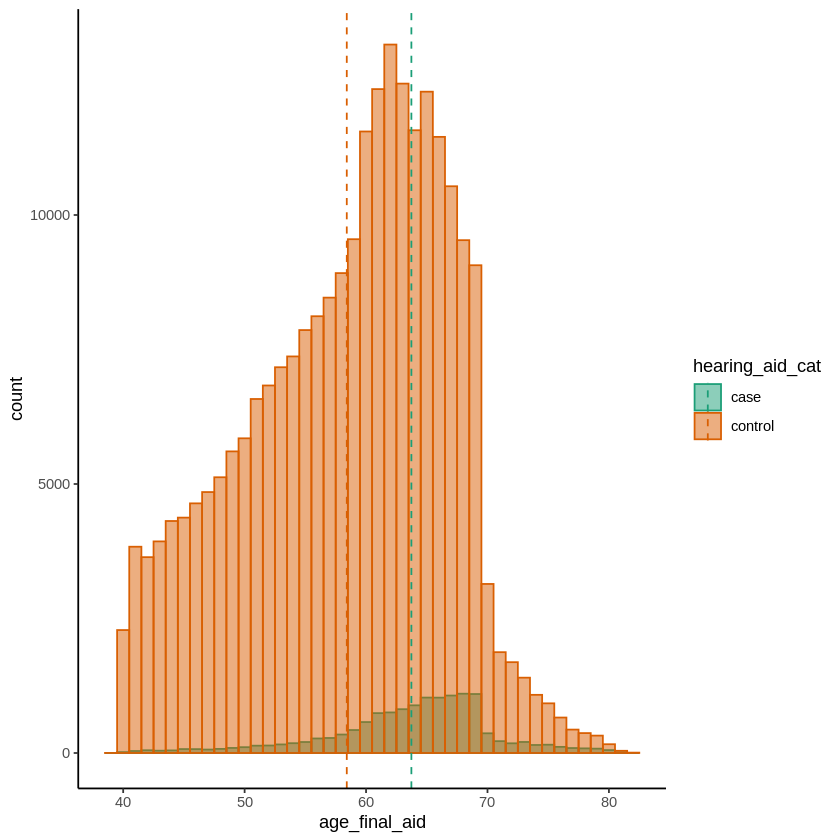

In [37]:
ggplot(f.3393_pheno, aes(x=age_final_aid, fill=hearing_aid_cat, color=hearing_aid_cat)) +
 geom_histogram(binwidth=1, alpha=0.5, position="identity")+
  scale_color_brewer(palette="Dark2")+
  scale_fill_brewer(palette="Dark2") +
  theme(legend.position="top") +
  geom_vline(data=mu, aes(xintercept=grp.mean, color=hearing_aid_cat),
             linetype="dashed") +
  theme_classic()

In [38]:
length(which((f.3393_pheno$hearing_aid_cat=="control" & f.3393_pheno$age_final_aid <50)))

[1] 42601

In [39]:
length(which((f.3393_pheno$hearing_aid_cat=="case" & f.3393_pheno$age_final_aid <50)))

[1] 574

In [40]:
mu1 <- ddply(f.3393_pheno, "sex", summarise, grp.mean=mean(age_final_aid))
head(mu1)

,sex,grp.mean
,<fct>,<dbl>
1,male,58.34242
2,female,59.06478


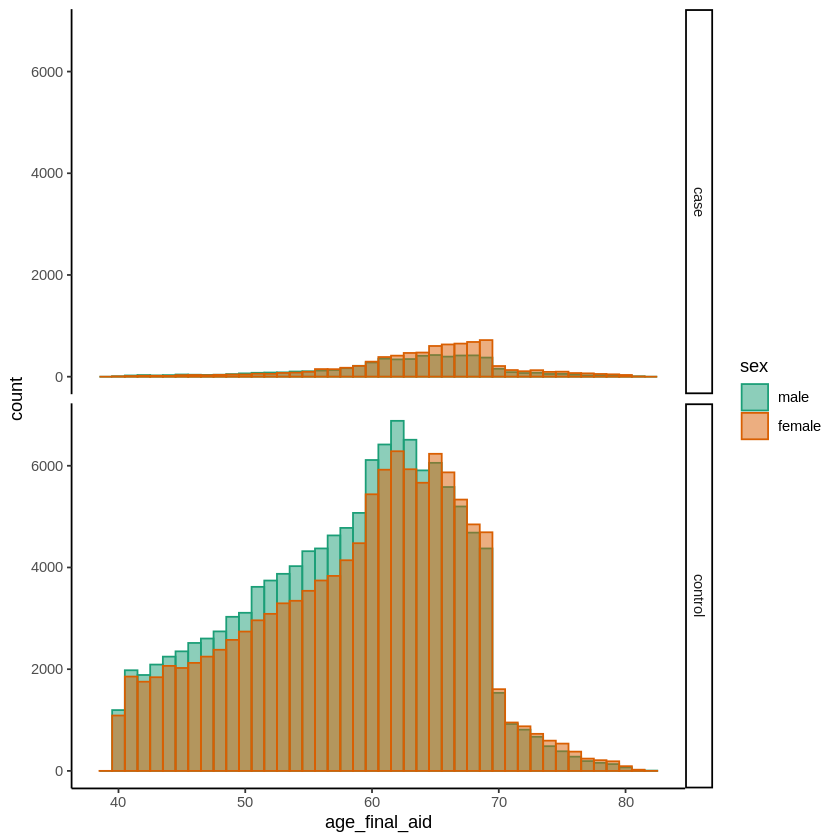

In [41]:
ggplot(f.3393_pheno, aes(x=age_final_aid, fill=sex, color=sex)) +
 geom_histogram(binwidth=1, alpha=0.5, position="identity")+
  scale_color_brewer(palette="Dark2")+
  scale_fill_brewer(palette="Dark2") +
  theme(legend.position="top") +
  theme_classic() +
  facet_grid(hearing_aid_cat ~ .)

## Find out controls positive for f.2247 & f.2257

In [42]:
control_check_3393 <- df_3393 %>%
    filter(hearing_aid_cat==0) %>%
    select(FID, IID, age_final_aid, sex, hearing_aid_cat, starts_with("f.2247"), starts_with("f.2257")) %>%
    mutate(remove_2247 = apply(select(.,starts_with("f.2247")), 1, function(x) length(which(x == "Yes")) > 0),
           remove_2257 = apply(select(.,starts_with("f.2257")), 1, function(x) length(which(x == "Yes")) > 0))
head(control_check_3393)

,FID,IID,age_final_aid,sex,hearing_aid_cat,f.2247.0.0,f.2247.1.0,f.2247.2.0,f.2247.3.0,f.2257.0.0,f.2257.1.0,f.2257.2.0,f.2257.3.0,remove_2247,remove_2257
,<int>,<int>,<int>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<lgl>,<lgl>
1,1000019,1000019,47,1,0,Yes,NA,NA,NA,Yes,NA,NA,NA,TRUE,TRUE
2,1000022,1000022,53,0,0,Yes,NA,NA,NA,Yes,NA,NA,NA,TRUE,TRUE
3,1000035,1000035,63,0,0,No,NA,NA,NA,Yes,NA,NA,NA,FALSE,TRUE
4,1000046,1000046,73,1,0,No,NA,No,NA,No,NA,Yes,NA,FALSE,TRUE
5,1000054,1000054,65,1,0,No,NA,NA,NA,Yes,NA,NA,NA,FALSE,TRUE
6,1000063,1000063,43,0,0,No,NA,NA,NA,No,NA,NA,NA,FALSE,FALSE


In [43]:
length(which(control_check_3393$remove_2247==TRUE)) #controls that replied yes to f.2247
length(which(control_check_3393$remove_2257==TRUE)) #controls that replied yes to f.2257
length(which(control_check_3393$remove_2247==TRUE & control_check_3393$remove_2257==TRUE)) # controls that replied yes to both
length(which(control_check_3393$remove_2247==TRUE | control_check_3393$remove_2257==TRUE)) # controls that replied yes to either

[1] 90190

[1] 139423

[1] 74437

[1] 155176

In [44]:
#write.table(f.3393_pheno, '200828_UKBB_Hearing_aid_f3393', quote = FALSE, row.names = FALSE)
write.table(f.3393_pheno, '120120_UKBB_Hearing_aid_f3393_expandedwhite', quote = FALSE, row.names = FALSE)

## Hearing difficulty/problems (2247)
### step1: classify cases and controls

In [45]:
table(df.final.imp$f.2247.0.0)
dim(df.final.imp)


         Do not know I am completely deaf                   No 
               15464                   67               284146 
Prefer not to answer                  Yes 
                 227                96503 

[1] 396976   1079

In [46]:
# Recode function:
recode<-function(df,column_name){
  new_names<-c()
  for (i in column_name){
    new_column_name<-paste0(i,"_recode")
    new_names<-c(new_names,new_column_name)
    df[,new_column_name] <- revalue(df[,i], c("No"= 0, 
                                            "Yes" =1,
                                            "Prefer not to answer"= NA,
                                             "Do not know"=9,
                                             "I am completely deaf"=NA))
  }
  return (list(df=df,new_column_names=new_names))
}

# columns needs to be recoded:
column_name<-c("f.2247.0.0","f.2247.1.0","f.2247.2.0","f.2247.3.0")

# get a new data.frame with recoded columns added:
df.final.imp<-recode(df=df.final.imp,column_name)$df

# get names of recoded columns:
new_column_names<-recode(df=df.final.imp,column_name)$new_column_names

# show recode summary:
for (i in new_column_names)
{cat(i,"summary:");print(table(df.final.imp[,i]));cat("\n")}

The following `from` values were not present in `x`: I am completely deaf

The following `from` values were not present in `x`: I am completely deaf



f.2247.0.0_recode summary:
     9      0      1 
 15464 284146  96503 

f.2247.1.0_recode summary:
    9     0     1 
  881 10667  5307 

f.2247.2.0_recode summary:
    9     0     1 
 2161 24200 13263 

f.2247.3.0_recode summary:
   9    0    1 
 138 1595  889 



## f.2247 Get possible answers

In [47]:
# Extract subset of data only with the recode columns of tinnitus
data_sub <- df.final.imp %>%
  select("IID",all_of(new_column_names)) 

# Function to extract all the available answers for 4 visits
# and put them in one string as "0000", "111", "991", etc

f2<-function(x){
  visit<-''
  for (i in 2:5){ # do not take the first column (i.e. IID)
    if (!is.na(x[i]))
    {visit<-paste0(visit,x[i])}
  }
  if(is.null(visit)){visit=NA}
  else{visit=visit}
  return (visit)
}

# Apply the above function and remove NAs
data_sub$visit<-apply(data_sub, 1, f2)

names(table(data_sub$visit))

[1] ""     "0"    "00"   "000"  "0000" "0001" "0009" "001"  "0010" "0011"
[11] "0019" "009"  "0090" "0091" "0099" "01"   "010"  "0100" "0101" "011" 
[21] "0110" "0111" "019"  "0190" "09"   "090"  "0900" "0901" "0909" "091" 
[31] "0911" "099"  "0990" "0991" "0999" "1"    "10"   "100"  "1000" "1001"
[41] "101"  "1010" "1011" "1019" "109"  "1090" "1099" "11"   "110"  "1100"
[51] "1101" "111"  "1111" "1119" "119"  "1190" "19"   "190"  "1900" "191" 
[61] "1910" "1911" "199"  "9"    "90"   "900"  "9000" "9001" "9009" "901" 
[71] "9011" "909"  "9090" "9099" "91"   "910"  "911"  "9111" "919"  "99"  
[81] "990"  "991"  "999"  "9990"

In [48]:
table(data_sub$visit)
all_pattern<-unique(data_sub$visit)


            0     00    000   0000   0001   0009    001   0010   0011   0019 
   479 248462  22804   4291    237     23     12    504     11     24      2 
   009   0090   0091   0099     01    010   0100   0101    011   0110   0111 
   177      5      3      2   5100    193      6      3    567      3     26 
   019   0190     09    090   0900   0901   0909    091   0911    099   0990 
    38      1   1551    138      4      3      2     84      1     77      1 
  0991   0999      1     10    100   1000   1001    101   1010   1011   1019 
     3      3  84892   1454    171      5      2    110      1      5      1 
   109   1090   1099     11    110   1100   1101    111   1111   1119    119 
    14      4      1   7880    119      2      4   1415     69      1     40 
  1190     19    190   1900    191   1910   1911    199      9     90    900 
     2    380     22      1     30      1      2     19  13723    575     93 
  9000   9001   9009    901   9011    909   9090   9099     91 

## f.2247 Get all the consistent cases

In [49]:
all_no<-all_pattern[which(grepl("0",all_pattern) & !grepl("9",all_pattern) & !grepl("1",all_pattern))]
all_yes<-all_pattern[which(!grepl("0",all_pattern) & !grepl("9",all_pattern) & grepl("1",all_pattern))]
all_do_not_know<-all_pattern[which(!grepl("0",all_pattern) & grepl("9",all_pattern) & !grepl("1",all_pattern))]
table(data_sub[data_sub$visit%in%union(union(all_no,all_yes),all_do_not_know),"visit"])


     0     00    000   0000      1     11    111   1111      9     99    999 
248462  22804   4291    237  84892   7880   1415     69  13723    279     28 

In [50]:
consistent_1<-c(all_no,all_yes,all_do_not_know)

# might be inconsistent cases:
do_not_know_no<-all_pattern[which(grepl("0",all_pattern) & grepl("9",all_pattern) & !grepl("1",all_pattern))]
table(data_sub[data_sub$visit%in%do_not_know_no,"visit"])


0009  009 0090 0099   09  090 0900 0909  099 0990 0999   90  900 9000 9009  909 
  12  177    5    2 1551  138    4    2   77    1    3  575   93    4    1   23 
9090 9099  990 9990 
   1    1   29    1 

In [51]:
do_not_know_yes<-all_pattern[which(!grepl("0",all_pattern) & grepl("9",all_pattern) & grepl("1",all_pattern))]
table(data_sub[data_sub$visit%in%do_not_know_yes,"visit"])


1119  119   19  191 1911  199   91  911 9111  919  991 
   1   40  380   30    2   19  587   87    1    3   23 

In [52]:
yes_no<-all_pattern[which(grepl("0",all_pattern) & !grepl("9",all_pattern) & grepl("1",all_pattern))]
table(data_sub[data_sub$visit%in%yes_no,"visit"])


0001  001 0010 0011   01  010 0100 0101  011 0110 0111   10  100 1000 1001  101 
  23  504   11   24 5100  193    6    3  567    3   26 1454  171    5    2  110 
1010 1011  110 1100 1101 
   1    5  119    2    4 

In [53]:
with_all_three<-all_pattern[which(grepl("0",all_pattern) & grepl("9",all_pattern) & grepl("1",all_pattern))]
table(data_sub[data_sub$visit%in%with_all_three,"visit"])


0019 0091  019 0190 0901  091 0911 0991 1019  109 1090 1099 1190  190 1900 1910 
   2    3   38    1    3   84    1    3    1   14    4    1    2   22    1    1 
9001  901 9011  910 
   1   18    1   10 

In [54]:
might_inconsistent<-c(do_not_know_no,do_not_know_yes,yes_no,with_all_three)

## f.2247 Remove inconsistent cases

In [55]:
# get all the inconsistent cases:
exceptions<-c("91","911","9111","991","0001","001","0011","01","011","0111", "0091", "091","0911","0991","9001","901","9011")
inconsistent<-setdiff(might_inconsistent,exceptions)

cat("There are",length(which(is.empty(data_sub$visit))),"NAs, removed")

There are 479 NAs, removed

In [56]:
cat("There are",length(which(data_sub$visit%in%inconsistent)),"inconsistent cases, removed")

There are 5364 inconsistent cases, removed

In [57]:
# removed those NAs, consistent for do not know - 9 and inconsistent cases: 
IID_hearing_diff<-data_sub %>%
  filter(!is.empty(visit)) %>%
  filter((!visit%in%inconsistent)) %>%
  filter((!visit%in%all_do_not_know)) %>%
  select(IID)

dim(IID_hearing_diff)

[1] 377103      1

In [58]:
IID_hearing_diff<-IID_hearing_diff[,1]
cat("After removing all the NAs and inconsistent cases, there are",length(IID_hearing_diff),"cases left")

After removing all the NAs and inconsistent cases, there are 377103 cases left

In [59]:
# get the dataset after cleansing: 
df.hearing.diff<-df.final.imp %>%
  filter(IID%in%IID_hearing_diff)

dim(df.hearing.diff)

[1] 377103   1083

## f.2247 Step 1 classify cases and controls

In [60]:
hearing_diff <- df.hearing.diff %>% 
  select(IID,FID,f.22001.0.0, f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.2247.0.0_recode,f.2247.1.0_recode,f.2247.2.0_recode,f.2247.3.0_recode)
head(hearing_diff)

,IID,FID,f.22001.0.0,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.2247.0.0_recode,f.2247.1.0_recode,f.2247.2.0_recode,f.2247.3.0_recode
,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>
1,1000019,1000019,Female,47,NA,NA,NA,1,NA,NA,NA
2,1000022,1000022,Male,53,NA,NA,NA,1,NA,NA,NA
3,1000035,1000035,Male,63,NA,NA,NA,0,NA,NA,NA
4,1000046,1000046,Female,62,NA,73,NA,0,NA,0,NA
5,1000054,1000054,Female,65,NA,NA,NA,0,NA,NA,NA
6,1000063,1000063,Male,43,NA,NA,NA,0,NA,NA,NA


In [61]:
data_sub <- select(hearing_diff,starts_with("f.2247"))

# Function to define cases
f<-function(x){
  visit<-c()
  for (i in 1:4){
    if (!is.na(x[i]))
    {visit<-c(visit,x[i])}
  }
  if ("1" %in% visit){result= TRUE}
  else{result=FALSE}
  return (result)
}

# Apply the above function
hearing_diff$cases<-apply(data_sub, 1, f)
head(hearing_diff,10)

,IID,FID,f.22001.0.0,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.2247.0.0_recode,f.2247.1.0_recode,f.2247.2.0_recode,f.2247.3.0_recode,cases
,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<lgl>
1,1000019,1000019,Female,47,NA,NA,NA,1,NA,NA,NA,TRUE
2,1000022,1000022,Male,53,NA,NA,NA,1,NA,NA,NA,TRUE
3,1000035,1000035,Male,63,NA,NA,NA,0,NA,NA,NA,FALSE
4,1000046,1000046,Female,62,NA,73,NA,0,NA,0,NA,FALSE
5,1000054,1000054,Female,65,NA,NA,NA,0,NA,NA,NA,FALSE
6,1000063,1000063,Male,43,NA,NA,NA,0,NA,NA,NA,FALSE
7,1000078,1000078,Female,52,57,60,NA,0,0,0,NA,FALSE
8,1000081,1000081,Male,67,NA,NA,NA,0,NA,NA,NA,FALSE
9,1000090,1000090,Female,64,NA,NA,NA,1,NA,NA,NA,TRUE


In [62]:
hearing_diff_cases <- hearing_diff %>% 
  filter(cases == TRUE)
head(hearing_diff_cases)
cat(dim(hearing_diff_cases)[1], "individuals are cases for f.2247")

,IID,FID,f.22001.0.0,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.2247.0.0_recode,f.2247.1.0_recode,f.2247.2.0_recode,f.2247.3.0_recode,cases
,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<lgl>
1,1000019,1000019,Female,47,NA,NA,NA,1,NA,NA,NA,TRUE
2,1000022,1000022,Male,53,NA,NA,NA,1,NA,NA,NA,TRUE
3,1000090,1000090,Female,64,NA,NA,NA,1,NA,NA,NA,TRUE
4,1000112,1000112,Male,58,NA,68,NA,9,NA,1,NA,TRUE
5,1000170,1000170,Female,51,NA,NA,NA,1,NA,NA,NA,TRUE
6,1000198,1000198,Female,41,NA,NA,NA,1,NA,NA,NA,TRUE


101309 individuals are cases for f.2247

In [63]:
hearing_diff_controls <- hearing_diff %>% 
  filter(cases == FALSE)
head(hearing_diff_controls)
cat(dim(hearing_diff_controls)[1], "individuals are controls for f.2247")

,IID,FID,f.22001.0.0,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.2247.0.0_recode,f.2247.1.0_recode,f.2247.2.0_recode,f.2247.3.0_recode,cases
,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<lgl>
1,1000035,1000035,Male,63,NA,NA,NA,0,NA,NA,NA,FALSE
2,1000046,1000046,Female,62,NA,73,NA,0,NA,0,NA,FALSE
3,1000054,1000054,Female,65,NA,NA,NA,0,NA,NA,NA,FALSE
4,1000063,1000063,Male,43,NA,NA,NA,0,NA,NA,NA,FALSE
5,1000078,1000078,Female,52,57,60,NA,0,0,0,NA,FALSE
6,1000081,1000081,Male,67,NA,NA,NA,0,NA,NA,NA,FALSE


275794 individuals are controls for f.2247

In [64]:
dim(hearing_diff)[1]-246072 - 91057

[1] 39974

## f.2247 Recode cases=1 and controls=0

In [65]:
hearing_diff$hearing_diff_cat <- as.integer(as.logical(hearing_diff$cases))
head(hearing_diff, 10)
# Get the number of NAs
length(which(is.na(hearing_diff$hearing_dif_cat)))

,IID,FID,f.22001.0.0,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.2247.0.0_recode,f.2247.1.0_recode,f.2247.2.0_recode,f.2247.3.0_recode,cases,hearing_diff_cat
,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<lgl>,<int>
1,1000019,1000019,Female,47,NA,NA,NA,1,NA,NA,NA,TRUE,1
2,1000022,1000022,Male,53,NA,NA,NA,1,NA,NA,NA,TRUE,1
3,1000035,1000035,Male,63,NA,NA,NA,0,NA,NA,NA,FALSE,0
4,1000046,1000046,Female,62,NA,73,NA,0,NA,0,NA,FALSE,0
5,1000054,1000054,Female,65,NA,NA,NA,0,NA,NA,NA,FALSE,0
6,1000063,1000063,Male,43,NA,NA,NA,0,NA,NA,NA,FALSE,0
7,1000078,1000078,Female,52,57,60,NA,0,0,0,NA,FALSE,0
8,1000081,1000081,Male,67,NA,NA,NA,0,NA,NA,NA,FALSE,0
9,1000090,1000090,Female,64,NA,NA,NA,1,NA,NA,NA,TRUE,1


[1] 0

## f.2247 Step 2: get the ages for hearing difficulty

In [66]:
# Get the subset data of cases
diff_age_cases = hearing_diff %>% 
  filter(hearing_diff_cat=="1")  %>%
  select(IID, f.2247.0.0_recode, f.2247.1.0_recode, f.2247.2.0_recode, f.2247.3.0_recode, f.21003.0.0, f.21003.1.0, f.21003.2.0, f.21003.3.0)
head(diff_age_cases,12)

,IID,f.2247.0.0_recode,f.2247.1.0_recode,f.2247.2.0_recode,f.2247.3.0_recode,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>
1,1000019,1,NA,NA,NA,47,NA,NA,NA
2,1000022,1,NA,NA,NA,53,NA,NA,NA
3,1000090,1,NA,NA,NA,64,NA,NA,NA
4,1000112,9,NA,1,NA,58,NA,68,NA
5,1000170,1,NA,NA,NA,51,NA,NA,NA
6,1000198,1,NA,NA,NA,41,NA,NA,NA
7,1000203,1,NA,NA,NA,49,NA,NA,NA
8,1000494,1,NA,NA,NA,61,NA,NA,NA
9,1000549,1,NA,NA,NA,63,NA,NA,NA


In [67]:
# Get the # of column where first replied Yes:
diff_age_cases$visit_idx = apply(diff_age_cases, 1, function(x) unlist(which(x == '1')))
head(diff_age_cases)

,IID,f.2247.0.0_recode,f.2247.1.0_recode,f.2247.2.0_recode,f.2247.3.0_recode,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,visit_idx
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<list>
1,1000019,1,NA,NA,NA,47,NA,NA,NA,2
2,1000022,1,NA,NA,NA,53,NA,NA,NA,2
3,1000090,1,NA,NA,NA,64,NA,NA,NA,2
4,1000112,9,NA,1,NA,58,NA,68,NA,4
5,1000170,1,NA,NA,NA,51,NA,NA,NA,2
6,1000198,1,NA,NA,NA,41,NA,NA,NA,2


In [68]:
# Define offset:
# offset: refers to the # of columns between the first age column (i.e.f.21003.0.0) and the first recode column (i.e.f.22247.0.0_recode)
offset = which(colnames(diff_age_cases) == 'f.21003.0.0') - which(colnames(diff_age_cases) == 'f.2247.0.0_recode')

# Define the function to extract the first time they said yes for cases 
f=get_age_func <- function(x) {
  visit_index=x[which(colnames(diff_age_cases)=="visit_idx")]
  index=min(unlist(visit_index))+offset
  age=x[index]
  final_age=unlist(age)
  if(is.null(final_age))
  {final_age<-NA}
  return(final_age)
}

# Get the final age for cases
diff_age_cases$age_final_diff = apply(diff_age_cases, 1, f)

# Show first 6 rows
head(diff_age_cases)
summary(diff_age_cases$age_final_diff)

,IID,f.2247.0.0_recode,f.2247.1.0_recode,f.2247.2.0_recode,f.2247.3.0_recode,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,visit_idx,age_final_diff
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<list>,<int>
1,1000019,1,NA,NA,NA,47,NA,NA,NA,2,47
2,1000022,1,NA,NA,NA,53,NA,NA,NA,2,53
3,1000090,1,NA,NA,NA,64,NA,NA,NA,2,64
4,1000112,9,NA,1,NA,58,NA,68,NA,4,68
5,1000170,1,NA,NA,NA,51,NA,NA,NA,2,51
6,1000198,1,NA,NA,NA,41,NA,NA,NA,2,41


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  39.00   54.00   61.00   59.34   65.00   82.00 

In [69]:
### Extract age for Control (2247)
diff_age_control <- hearing_diff %>% 
  filter(hearing_diff_cat == "0") %>%
  select(IID, f.2247.0.0_recode, f.2247.1.0_recode, f.2247.2.0_recode, f.2247.3.0_recode, f.21003.0.0, f.21003.1.0, f.21003.2.0, f.21003.3.0)
head(diff_age_control)

,IID,f.2247.0.0_recode,f.2247.1.0_recode,f.2247.2.0_recode,f.2247.3.0_recode,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>
1,1000035,0,NA,NA,NA,63,NA,NA,NA
2,1000046,0,NA,0,NA,62,NA,73,NA
3,1000054,0,NA,NA,NA,65,NA,NA,NA
4,1000063,0,NA,NA,NA,43,NA,NA,NA
5,1000078,0,0,0,NA,52,57,60,NA
6,1000081,0,NA,NA,NA,67,NA,NA,NA


In [70]:
# Get the # of column where last replied No:
diff_age_control$visit_idx = apply(diff_age_control, 1, function(x) unlist(which(x == '0')))

# Define offset:
# offset: refers to the # of columns between the first age column (i.e.f.21003.0.0) and the first recode column (i.e.f.3393.0.0_recode)
offset = which(colnames(diff_age_control) == 'f.21003.0.0') - which(colnames(diff_age_control) == 'f.2247.0.0_recode')

# Define the function to extract the last time they said no for control

f=get_age_func <- function(x) {
  visit_index=x[which(colnames(diff_age_control)=="visit_idx")]
  index=max(unlist(visit_index))+offset
  age=x[index]
  age=unlist(age)
  return(age)
}

# Get the final age for controls
diff_age_control$age_final_diff = apply(diff_age_control, 1, f)

# Show first 6 rows
head(diff_age_control)
summary(diff_age_control$age_final_diff)

,IID,f.2247.0.0_recode,f.2247.1.0_recode,f.2247.2.0_recode,f.2247.3.0_recode,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,visit_idx,age_final_diff
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<list>,<int>
1,1000035,0,NA,NA,NA,63,NA,NA,NA,2,63
2,1000046,0,NA,0,NA,62,NA,73,NA,"2, 4",73
3,1000054,0,NA,NA,NA,65,NA,NA,NA,2,65
4,1000063,0,NA,NA,NA,43,NA,NA,NA,2,43
5,1000078,0,0,0,NA,52,57,60,NA,"2, 3, 4",60
6,1000081,0,NA,NA,NA,67,NA,NA,NA,2,67


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  39.00   50.00   58.00   56.81   63.00   82.00 

In [71]:
# Merge age_cases and age_controls
hearing_diff_age <- rbind(diff_age_cases, diff_age_control) 
dim(hearing_diff_age)
head(hearing_diff_age)

[1] 377103     11

,IID,f.2247.0.0_recode,f.2247.1.0_recode,f.2247.2.0_recode,f.2247.3.0_recode,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,visit_idx,age_final_diff
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<list>,<int>
1,1000019,1,NA,NA,NA,47,NA,NA,NA,2,47
2,1000022,1,NA,NA,NA,53,NA,NA,NA,2,53
3,1000090,1,NA,NA,NA,64,NA,NA,NA,2,64
4,1000112,9,NA,1,NA,58,NA,68,NA,4,68
5,1000170,1,NA,NA,NA,51,NA,NA,NA,2,51
6,1000198,1,NA,NA,NA,41,NA,NA,NA,2,41


In [72]:
hearing_diff_age = merge(x = hearing_diff ,y = hearing_diff_age [,c("IID","age_final_diff")],by="IID", all.x=TRUE)
head(hearing_diff_age)
dim(hearing_diff_age)

,IID,FID,f.22001.0.0,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.2247.0.0_recode,f.2247.1.0_recode,f.2247.2.0_recode,f.2247.3.0_recode,cases,hearing_diff_cat,age_final_diff
,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<lgl>,<int>,<int>
1,1000019,1000019,Female,47,NA,NA,NA,1,NA,NA,NA,TRUE,1,47
2,1000022,1000022,Male,53,NA,NA,NA,1,NA,NA,NA,TRUE,1,53
3,1000035,1000035,Male,63,NA,NA,NA,0,NA,NA,NA,FALSE,0,63
4,1000046,1000046,Female,62,NA,73,NA,0,NA,0,NA,FALSE,0,73
5,1000054,1000054,Female,65,NA,NA,NA,0,NA,NA,NA,FALSE,0,65
6,1000063,1000063,Male,43,NA,NA,NA,0,NA,NA,NA,FALSE,0,43


[1] 377103     14

## Merge dataset from f.3393 and f.2247

In [73]:
#Merge with complete database keep the all the rows from original db
df_3393_2247 = merge(x = df_3393, y = hearing_diff_age [,c("IID","hearing_diff_cat","age_final_diff")],by="IID", all.x=TRUE)
dim(df_3393_2247)
head(df_3393_2247)

[1] 396976   1083

,IID,FID,ignore1,ignore2,ignore3,ignore4,f.31.0.0,f.34.0.0,f.53.0.0,f.53.1.0,⋯,f.41281.0.46,sex,f.3393.0.0_recode,f.3393.1.0_recode,f.3393.2.0_recode,f.3393.3.0_recode,hearing_aid_cat,age_final_aid,hearing_diff_cat,age_final_diff
,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<int>,<fct>,<fct>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>
1,1000019,1000019,0,0,2,-9,Female,1960,2008-01-24,NA,⋯,NA,1,0,NA,NA,NA,0,47,1,47
2,1000022,1000022,0,0,1,-9,Male,1954,2008-01-22,NA,⋯,NA,0,0,NA,NA,NA,0,53,1,53
3,1000035,1000035,0,0,1,-9,Male,1944,2007-11-08,NA,⋯,NA,0,0,NA,NA,NA,0,63,0,63
4,1000046,1000046,0,0,2,-9,Female,1946,2008-12-01,NA,⋯,NA,1,NA,NA,0,NA,0,73,0,73
5,1000054,1000054,0,0,2,-9,Female,1942,2007-11-23,NA,⋯,NA,1,0,NA,NA,NA,0,65,0,65
6,1000063,1000063,0,0,1,-9,Male,1967,2010-06-26,NA,⋯,NA,0,0,NA,NA,NA,0,43,0,43


## Reclassify individuals wearing hearing aid f.3393 but saying they don't have hearing difficulty f.2247

In [74]:
#reclassify these 85 individulas as cases for 2247
df_3393_2247$hearing_diff_cat_new <- as.factor(df_3393_2247$hearing_diff_cat)
df_3393_2247$hearing_diff_cat_new <- revalue(df_3393_2247$hearing_diff_cat_new, c('0' = "control", '1' = 'case' ))
df_3393_2247$hearing_aid_cat_new <- as.factor(df_3393_2247$hearing_aid_cat)
df_3393_2247$hearing_aid_cat_new <- revalue(df_3393_2247$hearing_aid_cat_new, c('0' = "control", '1' = 'case' ))
#hearing_diff_new <- df_3393_2247 %>% 
 # mutate(hearing_diff_cat_new =ifelse(IID%in%inconsistent_aid_diff,1,hearing_diff_cat_new))
#head(hearing_diff_new)

In [75]:
246072 + 91057 # number of controls and cases

[1] 337129

In [76]:
length(which(df_3393_2247$hearing_diff_cat_new == 'control' & df_3393_2247$hearing_aid_cat_new == 'case'))

[1] 112

In [77]:
#85 individuals state they have no hearing difficulty but they wear hearing aids
inconsistent_aid_diff <- df_3393_2247 %>%
    filter(hearing_diff_cat_new == 'control' & hearing_aid_cat_new == 'case') %>%
    select(IID)
nrow(inconsistent_aid_diff)
head(inconsistent_aid_diff)

[1] 112

,IID
,<int>
1,1011166
2,1085722
3,1156617
4,1178338
5,1200917
6,1210033


In [78]:
inconsistent_aid_diff<-unlist(inconsistent_aid_diff[,1])
cat("There are",length(inconsistent_aid_diff),"individuals that state having no hearing difficulty but wear hearing aid")

There are 112 individuals that state having no hearing difficulty but wear hearing aid

In [79]:
df_3393_2247$hearing_diff_new <- df_3393_2247$hearing_diff_cat_new
df_3393_2247$hearing_diff_new[df_3393_2247$IID %in% inconsistent_aid_diff] <- "case"

In [80]:
#91057 individuals plus 85 that wear hearing aid = 91142
check_merge <- df_3393_2247 %>% 
  select(hearing_diff_cat_new, hearing_aid_cat_new, hearing_diff_new) %>%
  filter(hearing_diff_new == "case")
head(check_merge)
nrow(check_merge)

,hearing_diff_cat_new,hearing_aid_cat_new,hearing_diff_new
,<fct>,<fct>,<fct>
1,case,control,case
2,case,control,case
3,case,control,case
4,case,case,case
5,case,control,case
6,case,control,case


[1] 101421

## f.2247 Verify the age for the new 85 cases

In [81]:
age_inconsistent <- df_3393_2247 %>%
    select(IID, age_final_aid, age_final_diff) %>%
    filter(IID %in% inconsistent_aid_diff)
head(age_inconsistent, 100)

,IID,age_final_aid,age_final_diff
,<int>,<int>,<int>
1,1011166,52,52
2,1085722,43,43
3,1156617,65,65
4,1178338,40,40
5,1200917,70,70
6,1210033,60,60
7,1272322,45,45
8,1362299,45,45
9,1452961,69,69


In [82]:
# There are not inconsistencies in the age of the 85 new cases therefore I can use the age_final_diff variable
all(age_inconsistent$age_final_aid == age_inconsistent$age_final_diff)

[1] TRUE

## Export file for hearing difficulty f.2247

In [83]:
df_3393_2247$hearing_diff_new <- revalue(df_3393_2247$hearing_diff_new, c('control' = "0", 'case' = '1' ))

In [84]:
f.2247_pheno <- df_3393_2247 %>%
    filter(!(is.na(hearing_diff_new))) %>%
    select(FID, IID, age_final_diff, sex, hearing_diff_new)
head(f.2247_pheno)
dim(f.2247_pheno)

,FID,IID,age_final_diff,sex,hearing_diff_new
,<int>,<int>,<int>,<fct>,<fct>
1,1000019,1000019,47,1,1
2,1000022,1000022,53,0,1
3,1000035,1000035,63,0,0
4,1000046,1000046,73,1,0
5,1000054,1000054,65,1,0
6,1000063,1000063,43,0,0


[1] 377103      5

## Histogram for age in f.2247

In [85]:
mu3 <- ddply(f.2247_pheno, "hearing_diff_new", summarise, grp.mean=mean(age_final_diff))
head(mu3)

,hearing_diff_new,grp.mean
,<fct>,<dbl>
1,0,56.81456
2,1,59.33226


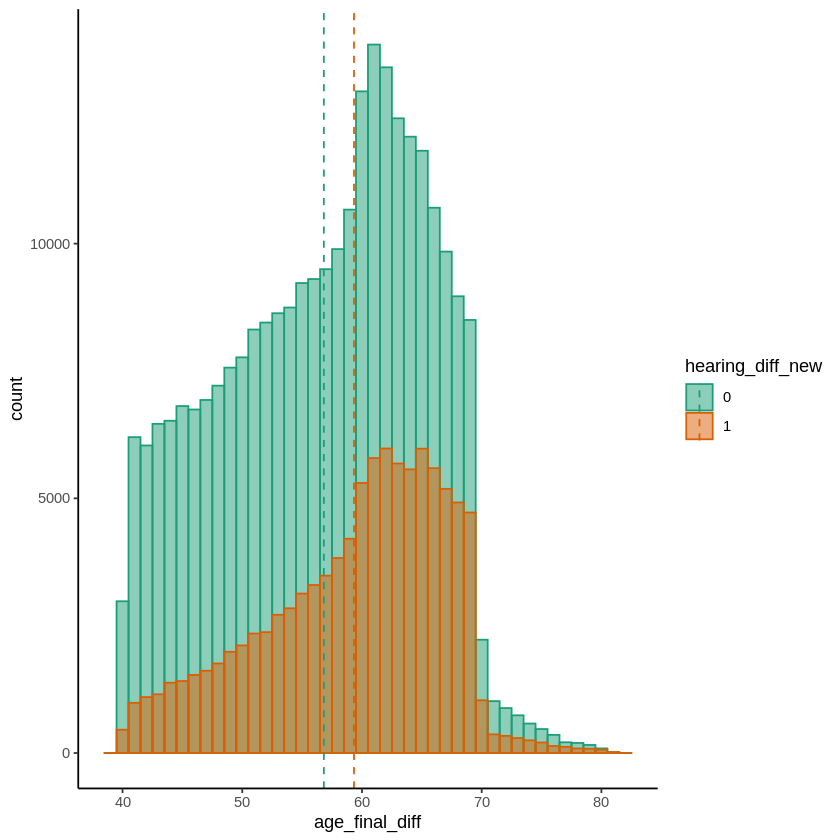

In [86]:
ggplot(f.2247_pheno, aes(x=age_final_diff, fill=hearing_diff_new, color=hearing_diff_new)) +
 geom_histogram(binwidth=1, alpha=0.5, position="identity")+
  scale_color_brewer(palette="Dark2")+
  scale_fill_brewer(palette="Dark2") +
  theme(legend.position="top") +
  geom_vline(data=mu3, aes(xintercept=grp.mean, color=hearing_diff_new),
             linetype="dashed") +
  theme_classic()

In [87]:
length(which((f.2247_pheno$hearing_diff_new=="control" & f.2247_pheno$age_final_diff <50)))
length(which((f.2247_pheno$hearing_diff_new=="case" & f.2247_pheno$age_final_diff <50)))

[1] 0

[1] 0

In [88]:
mu4 <- ddply(f.2247_pheno, "sex", summarise, grp.mean=mean(age_final_diff))
head(mu1)

,sex,grp.mean
,<fct>,<dbl>
1,male,58.34242
2,female,59.06478


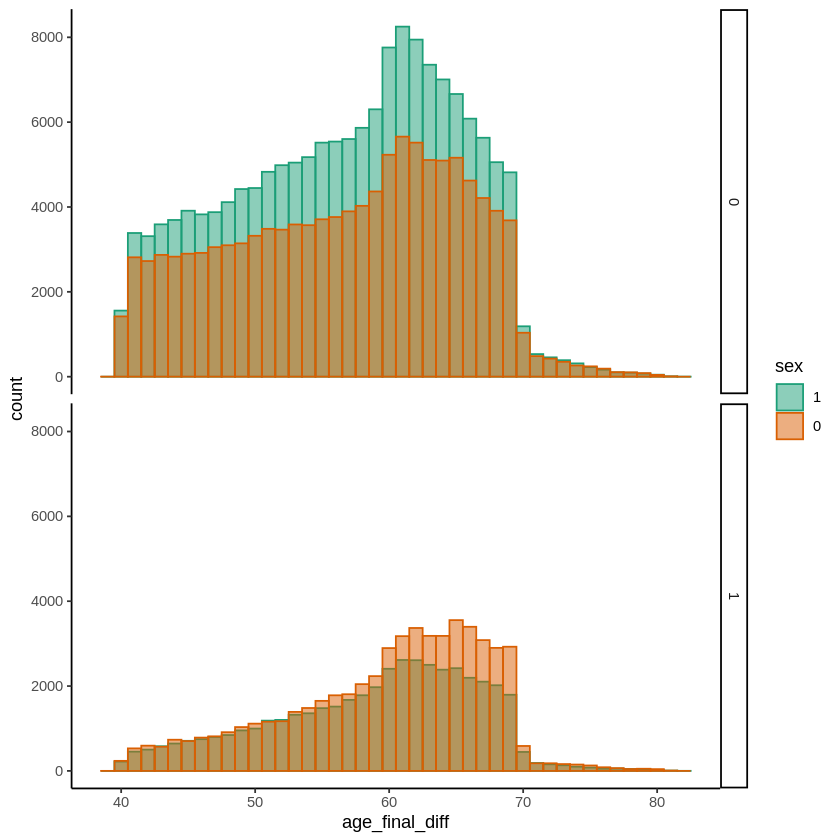

In [89]:
ggplot(f.2247_pheno, aes(x=age_final_diff, fill=sex, color=sex)) +
 geom_histogram(binwidth=1, alpha=0.5, position="identity")+
  scale_color_brewer(palette="Dark2")+
  scale_fill_brewer(palette="Dark2") +
  theme(legend.position="top") +
  theme_classic() +
  facet_grid(hearing_diff_new ~ .)

In [90]:
## Filter controls positive for f.3393 and/or f.2257

In [91]:
control_check_2247 <- df_3393_2247 %>%
    filter(hearing_diff_new==0) %>%
    select(FID, IID, age_final_diff, sex, hearing_diff_new, starts_with("f.2257"), starts_with("f.3393")) %>%
    mutate(remove_2257 = apply(select(.,starts_with("f.2257")), 1, function(x) length(which(x == "Yes")) > 0),
           remove_3393 = apply(select(.,starts_with("f.3393")), 1, function(x) length(which(x == "Yes")) > 0))
head(control_check_2247)

,FID,IID,age_final_diff,sex,hearing_diff_new,f.2257.0.0,f.2257.1.0,f.2257.2.0,f.2257.3.0,f.3393.0.0,f.3393.1.0,f.3393.2.0,f.3393.3.0,f.3393.0.0_recode,f.3393.1.0_recode,f.3393.2.0_recode,f.3393.3.0_recode,remove_2257,remove_3393
,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<lgl>,<lgl>
1,1000035,1000035,63,0,0,Yes,NA,NA,NA,No,NA,NA,NA,0,NA,NA,NA,TRUE,FALSE
2,1000046,1000046,73,1,0,No,NA,Yes,NA,NA,NA,No,NA,NA,NA,0,NA,TRUE,FALSE
3,1000054,1000054,65,1,0,Yes,NA,NA,NA,No,NA,NA,NA,0,NA,NA,NA,TRUE,FALSE
4,1000063,1000063,43,0,0,No,NA,NA,NA,No,NA,NA,NA,0,NA,NA,NA,FALSE,FALSE
5,1000078,1000078,60,1,0,No,No,No,NA,NA,No,No,NA,NA,0,0,NA,FALSE,FALSE
6,1000081,1000081,67,0,0,No,NA,NA,NA,No,NA,NA,NA,0,NA,NA,NA,FALSE,FALSE


In [92]:
length(which(control_check_2247$remove_2257==TRUE)) #controls that replied yes to f.2247
length(which(control_check_2247$remove_3393==TRUE)) #controls that replied yes to f.2257
length(which(control_check_2247$remove_2257==TRUE & control_check_2247$remove_3393==TRUE)) # controls that replied yes to both
length(which(control_check_2247$remove_2257==TRUE | control_check_2247$remove_3393==TRUE)) # controls that replied yes to either

[1] 56117

[1] 3

[1] 2

[1] 56118

In [93]:
#write.table(f.2247_pheno, '200828_UKBB_Hearing_difficulty_f2247', quote = FALSE, row.names = FALSE)
write.table(f.2247_pheno, '120120_UKBB_Hearing_difficulty_f2247_expandedwhite', quote = FALSE, row.names = FALSE)

## f.2257 Hearing difficulty/background noise (2257)
### step1: classify cases and controls

In [94]:
table(df.final.imp$f.2257.0.0)
dim(df.final.imp)


         Do not know                   No Prefer not to answer 
                7519               243931                  287 
                 Yes 
              144965 

[1] 396976   1083

In [95]:
# Recode function:
recode<-function(df,column_name){
  new_names<-c()
  for (i in column_name){
    new_column_name<-paste0(i,"_recode")
    new_names<-c(new_names,new_column_name)
    df[,new_column_name] <- revalue(df[,i], c("No"= 0, 
                                            "Yes" =1,
                                            "Prefer not to answer"= NA,
                                             "Do not know"=9))
  }
  return (list(df=df,new_column_names=new_names))
}

# columns needs to be recoded:
column_name<-c("f.2257.0.0","f.2257.1.0","f.2257.2.0","f.2257.3.0")

# get a new data.frame with recoded columns added:
df.final.imp<-recode(df=df.final.imp,column_name)$df

# get names of recoded columns:
new_column_names<-recode(df=df.final.imp,column_name)$new_column_names

# show recode summary:
for (i in new_column_names)
{cat(i,"summary:");print(table(df.final.imp[,i]));cat("\n")}

f.2257.0.0_recode summary:
     9      0      1 
  7519 243931 144965 

f.2257.1.0_recode summary:
   9    0    1 
 356 9364 7136 

f.2257.2.0_recode summary:
    9     0     1 
  887 21098 17628 

f.2257.3.0_recode summary:
   9    0    1 
  58 1406 1157 



In [96]:
dim(df.final.imp)

[1] 396976   1087

## f.2257 Get patterns for all possible answers

In [97]:
# Extract subset of data only with the recode columns of tinnitus
data_sub <- df.final.imp %>%
  select("IID",all_of(new_column_names)) 

# Function to extract all the available answers for 4 visits
# and put them in one string as "0000", "111", "991", etc

f2<-function(x){
  visit<-''
  for (i in 2:5){ # do not take the first column (i.e. IID)
    if (!is.na(x[i]))
    {visit<-paste0(visit,x[i])}
  }
  if(is.null(visit)){visit=NA}
  else{visit=visit}
  return (visit)
}

# Apply the above function and remove NAs
data_sub$visit<-apply(data_sub, 1, f2)

names(table(data_sub$visit))

[1] ""     "0"    "00"   "000"  "0000" "0001" "0009" "001"  "0010" "0011"
[11] "0019" "009"  "0090" "0091" "01"   "010"  "0100" "0101" "011"  "0110"
[21] "0111" "019"  "09"   "090"  "0900" "0901" "091"  "0911" "099"  "1"   
[31] "10"   "100"  "1000" "1001" "101"  "1010" "1011" "109"  "11"   "110" 
[41] "1100" "1101" "111"  "1110" "1111" "1119" "119"  "19"   "190"  "1900"
[51] "191"  "199"  "9"    "90"   "900"  "9000" "9001" "901"  "9011" "909" 
[61] "91"   "910"  "911"  "9110" "9111" "919"  "9191" "99"   "990"  "991" 
[71] "999"  "9991" "9999"

In [98]:
table(data_sub$visit)
all_pattern<-unique(data_sub$visit)


            0     00    000   0000   0001   0009    001   0010   0011   0019 
   529 213235  18861   3521    190     25      3    586     12     26      1 
   009   0090   0091     01    010   0100   0101    011   0110   0111    019 
    72      5      3   5699    294      9      7    651      7     29     23 
    09    090   0900   0901    091   0911    099      1     10    100   1000 
   573     60      3      1     33      2     12 126905   2594    330      9 
  1001    101   1010   1011    109     11    110   1100   1101    111   1110 
     5    233      2      9     17  12013    197      9      6   2219      7 
  1111   1119    119     19    190   1900    191    199      9     90    900 
   112      1     31    234     14      2     26      5   6701    288     38 
  9000   9001    901   9011    909     91    910    911   9110   9111    919 
     2      1     13      1      7    294     10     32      1      2      7 
  9191     99    990    991    999   9991   9999 
     1     94

## f.2257 Get all the consitent cases

In [99]:
all_no<-all_pattern[which(grepl("0",all_pattern) & !grepl("9",all_pattern) & !grepl("1",all_pattern))]
all_yes<-all_pattern[which(!grepl("0",all_pattern) & !grepl("9",all_pattern) & grepl("1",all_pattern))]
all_do_not_know<-all_pattern[which(!grepl("0",all_pattern) & grepl("9",all_pattern) & !grepl("1",all_pattern))]
table(data_sub[data_sub$visit%in%union(union(all_no,all_yes),all_do_not_know),"visit"])


     0     00    000   0000      1     11    111   1111      9     99    999 
213235  18861   3521    190 126905  12013   2219    112   6701     94     12 
  9999 
     2 

In [100]:
consistent_1<-c(all_no,all_yes,all_do_not_know)

# might be inconsistent cases:
do_not_know_no<-all_pattern[which(grepl("0",all_pattern) & grepl("9",all_pattern) & !grepl("1",all_pattern))]
table(data_sub[data_sub$visit%in%do_not_know_no,"visit"])


0009  009 0090   09  090 0900  099   90  900 9000  909  990 
   3   72    5  573   60    3   12  288   38    2    7    8 

In [101]:
do_not_know_yes<-all_pattern[which(!grepl("0",all_pattern) & grepl("9",all_pattern) & grepl("1",all_pattern))]
table(data_sub[data_sub$visit%in%do_not_know_yes,"visit"])


1119  119   19  191  199   91  911 9111  919 9191  991 9991 
   1   31  234   26    5  294   32    2    7    1    9    1 

In [102]:
yes_no<-all_pattern[which(grepl("0",all_pattern) & !grepl("9",all_pattern) & grepl("1",all_pattern))]
table(data_sub[data_sub$visit%in%yes_no,"visit"])


0001  001 0010 0011   01  010 0100 0101  011 0110 0111   10  100 1000 1001  101 
  25  586   12   26 5699  294    9    7  651    7   29 2594  330    9    5  233 
1010 1011  110 1100 1101 1110 
   2    9  197    9    6    7 

In [103]:
with_all_three<-all_pattern[which(grepl("0",all_pattern) & grepl("9",all_pattern) & grepl("1",all_pattern))]
table(data_sub[data_sub$visit%in%with_all_three,"visit"])


0019 0091  019 0901  091 0911  109  190 1900 9001  901 9011  910 9110 
   1    3   23    1   33    2   17   14    2    1   13    1   10    1 

In [104]:
might_inconsistent<-c(do_not_know_no,do_not_know_yes,yes_no,with_all_three)

## f.2257 Remove all the inconsistent

In [105]:
# get all the inconsistent cases:
exceptions<-c("91","911","9111","991","9991","0001","001","0011","01","011","0111", "0091", "091","0911","9001","901","9011")
inconsistent<-setdiff(might_inconsistent,exceptions)

cat("There are",length(which(is.empty(data_sub$visit))),"NAs, removed")

There are 529 NAs, removed

In [106]:
cat("There are",length(which(data_sub$visit%in%inconsistent)),"inconsistent cases, removed")

There are 5175 inconsistent cases, removed

In [107]:
# removed those NAs, consistent for do not know - 9 and inconsistent cases: 
IID_hearing_noise<-data_sub %>%
  filter(!is.empty(visit)) %>%
  filter((!visit%in%inconsistent)) %>%
  filter((!visit%in%all_do_not_know)) %>%
  select(IID)

dim(IID_hearing_noise)

[1] 384463      1

In [108]:
IID_hearing_noise<-IID_hearing_noise[,1]
cat("After removing all the NAs and inconsistent cases, there are",length(IID_hearing_noise),"cases left")

After removing all the NAs and inconsistent cases, there are 384463 cases left

In [109]:
# get the dataset after cleansing: 
df.hearing.noise<-df.final.imp %>%
  filter(IID%in%IID_hearing_noise)

dim(df.hearing.noise)

[1] 384463   1087

## f.2257 Step 1 classify cases and controls

In [110]:
hearing_noise <- df.hearing.noise %>% 
  select(IID,FID,f.22001.0.0, f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.2257.0.0_recode,f.2257.1.0_recode,f.2257.2.0_recode,f.2257.3.0_recode)
head(hearing_noise)

,IID,FID,f.22001.0.0,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.2257.0.0_recode,f.2257.1.0_recode,f.2257.2.0_recode,f.2257.3.0_recode
,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>
1,1000019,1000019,Female,47,NA,NA,NA,1,NA,NA,NA
2,1000022,1000022,Male,53,NA,NA,NA,1,NA,NA,NA
3,1000035,1000035,Male,63,NA,NA,NA,1,NA,NA,NA
4,1000046,1000046,Female,62,NA,73,NA,0,NA,1,NA
5,1000054,1000054,Female,65,NA,NA,NA,1,NA,NA,NA
6,1000063,1000063,Male,43,NA,NA,NA,0,NA,NA,NA


In [111]:
data_sub <- select(hearing_noise,starts_with("f.2257"))

# Function to define cases
f<-function(x){
  visit<-c()
  for (i in 1:4){
    if (!is.na(x[i]))
    {visit<-c(visit,x[i])}
  }
  if ("1" %in% visit){result= TRUE}
  else{result=FALSE}
  return (result)
}

# Apply the above function
hearing_noise$cases<-apply(data_sub, 1, f)
head(hearing_noise,10)

,IID,FID,f.22001.0.0,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.2257.0.0_recode,f.2257.1.0_recode,f.2257.2.0_recode,f.2257.3.0_recode,cases
,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<lgl>
1,1000019,1000019,Female,47,NA,NA,NA,1,NA,NA,NA,TRUE
2,1000022,1000022,Male,53,NA,NA,NA,1,NA,NA,NA,TRUE
3,1000035,1000035,Male,63,NA,NA,NA,1,NA,NA,NA,TRUE
4,1000046,1000046,Female,62,NA,73,NA,0,NA,1,NA,TRUE
5,1000054,1000054,Female,65,NA,NA,NA,1,NA,NA,NA,TRUE
6,1000063,1000063,Male,43,NA,NA,NA,0,NA,NA,NA,FALSE
7,1000078,1000078,Female,52,57,60,NA,0,0,0,NA,FALSE
8,1000081,1000081,Male,67,NA,NA,NA,0,NA,NA,NA,FALSE
9,1000090,1000090,Female,64,NA,NA,NA,0,NA,NA,NA,FALSE


In [112]:
hearing_noise_cases <- hearing_noise %>% 
  filter(cases == TRUE)
head(hearing_noise_cases)
cat(dim(hearing_noise_cases)[1], "individuals are cases for f.2257")

,IID,FID,f.22001.0.0,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.2257.0.0_recode,f.2257.1.0_recode,f.2257.2.0_recode,f.2257.3.0_recode,cases
,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<lgl>
1,1000019,1000019,Female,47,NA,NA,NA,1,NA,NA,NA,TRUE
2,1000022,1000022,Male,53,NA,NA,NA,1,NA,NA,NA,TRUE
3,1000035,1000035,Male,63,NA,NA,NA,1,NA,NA,NA,TRUE
4,1000046,1000046,Female,62,NA,73,NA,0,NA,1,NA,TRUE
5,1000054,1000054,Female,65,NA,NA,NA,1,NA,NA,NA,TRUE
6,1000105,1000105,Female,54,NA,NA,NA,1,NA,NA,NA,TRUE


148656 individuals are cases for f.2257

In [113]:
hearing_noise_controls <- hearing_noise %>% 
  filter(cases == FALSE)
head(hearing_noise_controls)
cat(dim(hearing_noise_controls)[1], "individuals are controls for f.2257")

,IID,FID,f.22001.0.0,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.2257.0.0_recode,f.2257.1.0_recode,f.2257.2.0_recode,f.2257.3.0_recode,cases
,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<lgl>
1,1000063,1000063,Male,43,NA,NA,NA,0,NA,NA,NA,FALSE
2,1000078,1000078,Female,52,57,60,NA,0,0,0,NA,FALSE
3,1000081,1000081,Male,67,NA,NA,NA,0,NA,NA,NA,FALSE
4,1000090,1000090,Female,64,NA,NA,NA,0,NA,NA,NA,FALSE
5,1000129,1000129,Male,62,NA,NA,NA,0,NA,NA,NA,FALSE
6,1000137,1000137,Female,46,NA,NA,NA,0,NA,NA,NA,FALSE


235807 individuals are controls for f.2257

In [114]:
dim(hearing_noise)[1]-210733 - 132872

[1] 40858

## f.2257 Recode cases=1 and controls=0

In [115]:
hearing_noise$hearing_noise_cat <- as.integer(as.logical(hearing_noise$cases))
head(hearing_noise, 10)
# Get the number of NAs
length(which(is.na(hearing_noise$hearing_noise_cat)))

,IID,FID,f.22001.0.0,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.2257.0.0_recode,f.2257.1.0_recode,f.2257.2.0_recode,f.2257.3.0_recode,cases,hearing_noise_cat
,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<lgl>,<int>
1,1000019,1000019,Female,47,NA,NA,NA,1,NA,NA,NA,TRUE,1
2,1000022,1000022,Male,53,NA,NA,NA,1,NA,NA,NA,TRUE,1
3,1000035,1000035,Male,63,NA,NA,NA,1,NA,NA,NA,TRUE,1
4,1000046,1000046,Female,62,NA,73,NA,0,NA,1,NA,TRUE,1
5,1000054,1000054,Female,65,NA,NA,NA,1,NA,NA,NA,TRUE,1
6,1000063,1000063,Male,43,NA,NA,NA,0,NA,NA,NA,FALSE,0
7,1000078,1000078,Female,52,57,60,NA,0,0,0,NA,FALSE,0
8,1000081,1000081,Male,67,NA,NA,NA,0,NA,NA,NA,FALSE,0
9,1000090,1000090,Female,64,NA,NA,NA,0,NA,NA,NA,FALSE,0


[1] 0

## f.2257 Step 2: get the ages for hearing difficulty with background noise

In [116]:
# Get the subset data of cases
noise_age_cases = hearing_noise %>% 
  filter(hearing_noise_cat=="1")  %>%
  select(IID, f.2257.0.0_recode, f.2257.1.0_recode, f.2257.2.0_recode, f.2257.3.0_recode, f.21003.0.0, f.21003.1.0, f.21003.2.0, f.21003.3.0)
head(noise_age_cases,12)

,IID,f.2257.0.0_recode,f.2257.1.0_recode,f.2257.2.0_recode,f.2257.3.0_recode,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>
1,1000019,1,NA,NA,NA,47,NA,NA,NA
2,1000022,1,NA,NA,NA,53,NA,NA,NA
3,1000035,1,NA,NA,NA,63,NA,NA,NA
4,1000046,0,NA,1,NA,62,NA,73,NA
5,1000054,1,NA,NA,NA,65,NA,NA,NA
6,1000105,1,NA,NA,NA,54,NA,NA,NA
7,1000112,0,NA,1,NA,58,NA,68,NA
8,1000164,1,NA,NA,NA,51,NA,NA,NA
9,1000170,1,NA,NA,NA,51,NA,NA,NA


In [117]:
# Get the # of column where first replied Yes:
noise_age_cases$visit_idx = apply(noise_age_cases, 1, function(x) unlist(which(x == '1')))
head(noise_age_cases)

,IID,f.2257.0.0_recode,f.2257.1.0_recode,f.2257.2.0_recode,f.2257.3.0_recode,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,visit_idx
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<list>
1,1000019,1,NA,NA,NA,47,NA,NA,NA,2
2,1000022,1,NA,NA,NA,53,NA,NA,NA,2
3,1000035,1,NA,NA,NA,63,NA,NA,NA,2
4,1000046,0,NA,1,NA,62,NA,73,NA,4
5,1000054,1,NA,NA,NA,65,NA,NA,NA,2
6,1000105,1,NA,NA,NA,54,NA,NA,NA,2


In [118]:
# Define offset:
# offset: refers to the # of columns between the first age column (i.e.f.21003.0.0) and the first recode column (i.e.f.2257.0.0_recode)
offset = which(colnames(noise_age_cases) == 'f.21003.0.0') - which(colnames(noise_age_cases) == 'f.2257.0.0_recode')

# Define the function to extract the first time they said yes for cases 
f=get_age_func <- function(x) {
  visit_index=x[which(colnames(noise_age_cases)=="visit_idx")]
  index=min(unlist(visit_index))+offset
  age=x[index]
  final_age=unlist(age)
  if(is.null(final_age))
  {final_age<-NA}
  return(final_age)
}

# Get the final age for cases
noise_age_cases$age_final_noise = apply(noise_age_cases, 1, f)

# Show first 6 rows
head(noise_age_cases)
summary(noise_age_cases$age_final_noise)

,IID,f.2257.0.0_recode,f.2257.1.0_recode,f.2257.2.0_recode,f.2257.3.0_recode,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,visit_idx,age_final_noise
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<list>,<int>
1,1000019,1,NA,NA,NA,47,NA,NA,NA,2,47
2,1000022,1,NA,NA,NA,53,NA,NA,NA,2,53
3,1000035,1,NA,NA,NA,63,NA,NA,NA,2,63
4,1000046,0,NA,1,NA,62,NA,73,NA,4,73
5,1000054,1,NA,NA,NA,65,NA,NA,NA,2,65
6,1000105,1,NA,NA,NA,54,NA,NA,NA,2,54


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  40.00   53.00   60.00   58.39   65.00   82.00 

In [119]:
### Extract age for Control (2257)
noise_age_control <- hearing_noise %>% 
  filter(hearing_noise_cat == "0") %>%
  select(IID, f.2257.0.0_recode, f.2257.1.0_recode, f.2257.2.0_recode, f.2257.3.0_recode, f.21003.0.0, f.21003.1.0, f.21003.2.0, f.21003.3.0)
head(noise_age_control)

,IID,f.2257.0.0_recode,f.2257.1.0_recode,f.2257.2.0_recode,f.2257.3.0_recode,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>
1,1000063,0,NA,NA,NA,43,NA,NA,NA
2,1000078,0,0,0,NA,52,57,60,NA
3,1000081,0,NA,NA,NA,67,NA,NA,NA
4,1000090,0,NA,NA,NA,64,NA,NA,NA
5,1000129,0,NA,NA,NA,62,NA,NA,NA
6,1000137,0,NA,NA,NA,46,NA,NA,NA


In [120]:
# Get the # of column where last replied No:
noise_age_control$visit_idx = apply(noise_age_control, 1, function(x) unlist(which(x == '0')))

# Define offset:
# offset: refers to the # of columns between the first age column (i.e.f.21003.0.0) and the first recode column (i.e.f.2257.0.0_recode)
offset = which(colnames(noise_age_control) == 'f.21003.0.0') - which(colnames(noise_age_control) == 'f.2257.0.0_recode')

# Define the function to extract the last time they said no for control

f=get_age_func <- function(x) {
  visit_index=x[which(colnames(noise_age_control)=="visit_idx")]
  index=max(unlist(visit_index))+offset
  age=x[index]
  age=unlist(age)
  return(age)
}

# Get the final age for controls
noise_age_control$age_final_noise = apply(noise_age_control, 1, f)

# Show first 6 rows
head(noise_age_control)
summary(noise_age_control$age_final_noise)

,IID,f.2257.0.0_recode,f.2257.1.0_recode,f.2257.2.0_recode,f.2257.3.0_recode,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,visit_idx,age_final_noise
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<list>,<int>
1,1000063,0,NA,NA,NA,43,NA,NA,NA,2,43
2,1000078,0,0,0,NA,52,57,60,NA,"2, 3, 4",60
3,1000081,0,NA,NA,NA,67,NA,NA,NA,2,67
4,1000090,0,NA,NA,NA,64,NA,NA,NA,2,64
5,1000129,0,NA,NA,NA,62,NA,NA,NA,2,62
6,1000137,0,NA,NA,NA,46,NA,NA,NA,2,46


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  39.00   50.00   58.00   56.74   63.00   82.00 

In [121]:
# Merge age_cases and age_controls
hearing_noise_age <- rbind(noise_age_cases, noise_age_control) 
dim(hearing_noise_age)
head(hearing_noise_age)

[1] 384463     11

,IID,f.2257.0.0_recode,f.2257.1.0_recode,f.2257.2.0_recode,f.2257.3.0_recode,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,visit_idx,age_final_noise
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<list>,<int>
1,1000019,1,NA,NA,NA,47,NA,NA,NA,2,47
2,1000022,1,NA,NA,NA,53,NA,NA,NA,2,53
3,1000035,1,NA,NA,NA,63,NA,NA,NA,2,63
4,1000046,0,NA,1,NA,62,NA,73,NA,4,73
5,1000054,1,NA,NA,NA,65,NA,NA,NA,2,65
6,1000105,1,NA,NA,NA,54,NA,NA,NA,2,54


In [122]:
hearing_noise_age = merge(x = hearing_noise ,y = hearing_noise_age [,c("IID","age_final_noise")],by="IID", all.x=TRUE)
head(hearing_noise_age)
dim(hearing_noise_age)

,IID,FID,f.22001.0.0,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.2257.0.0_recode,f.2257.1.0_recode,f.2257.2.0_recode,f.2257.3.0_recode,cases,hearing_noise_cat,age_final_noise
,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<lgl>,<int>,<int>
1,1000019,1000019,Female,47,NA,NA,NA,1,NA,NA,NA,TRUE,1,47
2,1000022,1000022,Male,53,NA,NA,NA,1,NA,NA,NA,TRUE,1,53
3,1000035,1000035,Male,63,NA,NA,NA,1,NA,NA,NA,TRUE,1,63
4,1000046,1000046,Female,62,NA,73,NA,0,NA,1,NA,TRUE,1,73
5,1000054,1000054,Female,65,NA,NA,NA,1,NA,NA,NA,TRUE,1,65
6,1000063,1000063,Male,43,NA,NA,NA,0,NA,NA,NA,FALSE,0,43


[1] 384463     14

## Merge f.3393, f.2247 and f.2257

In [123]:
#Merge with complete database keep the all the rows from original db
df_3393_2247_2257 = merge(x = df_3393_2247, y = hearing_noise_age [,c("IID","hearing_noise_cat","age_final_noise")],by="IID", all.x=TRUE)
dim(df_3393_2247_2257)
head(df_3393_2247_2257)

[1] 396976   1088

,IID,FID,ignore1,ignore2,ignore3,ignore4,f.31.0.0,f.34.0.0,f.53.0.0,f.53.1.0,⋯,f.3393.3.0_recode,hearing_aid_cat,age_final_aid,hearing_diff_cat,age_final_diff,hearing_diff_cat_new,hearing_aid_cat_new,hearing_diff_new,hearing_noise_cat,age_final_noise
,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<int>,<fct>,<fct>,⋯,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<int>,<int>
1,1000019,1000019,0,0,2,-9,Female,1960,2008-01-24,NA,⋯,NA,0,47,1,47,case,control,1,1,47
2,1000022,1000022,0,0,1,-9,Male,1954,2008-01-22,NA,⋯,NA,0,53,1,53,case,control,1,1,53
3,1000035,1000035,0,0,1,-9,Male,1944,2007-11-08,NA,⋯,NA,0,63,0,63,control,control,0,1,63
4,1000046,1000046,0,0,2,-9,Female,1946,2008-12-01,NA,⋯,NA,0,73,0,73,control,control,0,1,73
5,1000054,1000054,0,0,2,-9,Female,1942,2007-11-23,NA,⋯,NA,0,65,0,65,control,control,0,1,65
6,1000063,1000063,0,0,1,-9,Male,1967,2010-06-26,NA,⋯,NA,0,43,0,43,control,control,0,0,43


## Export file for hearing with background noise f.2257

In [124]:
f.2257_pheno <- df_3393_2247_2257 %>%
    filter(!(is.na(hearing_noise_cat))) %>%
    select(FID, IID, age_final_noise, sex, hearing_noise_cat) %>%
    mutate(hearing_noise_cat=recode_factor(hearing_noise_cat, `1`="case",`0`="control"),
           sex=recode_factor(sex, `1`="male", `0`="female" ))
head(f.2257_pheno)
dim(f.2257_pheno)

,FID,IID,age_final_noise,sex,hearing_noise_cat
,<int>,<int>,<int>,<fct>,<fct>
1,1000019,1000019,47,male,case
2,1000022,1000022,53,female,case
3,1000035,1000035,63,female,case
4,1000046,1000046,73,male,case
5,1000054,1000054,65,male,case
6,1000063,1000063,43,female,control


[1] 384463      5

## Histogram for age of cases and controls

In [125]:
mu5 <- ddply(f.2257_pheno, "hearing_noise_cat", summarise, grp.mean=mean(age_final_noise))
head(mu)

,hearing_aid_cat,grp.mean
,<fct>,<dbl>
1,case,63.73215
2,control,58.41250


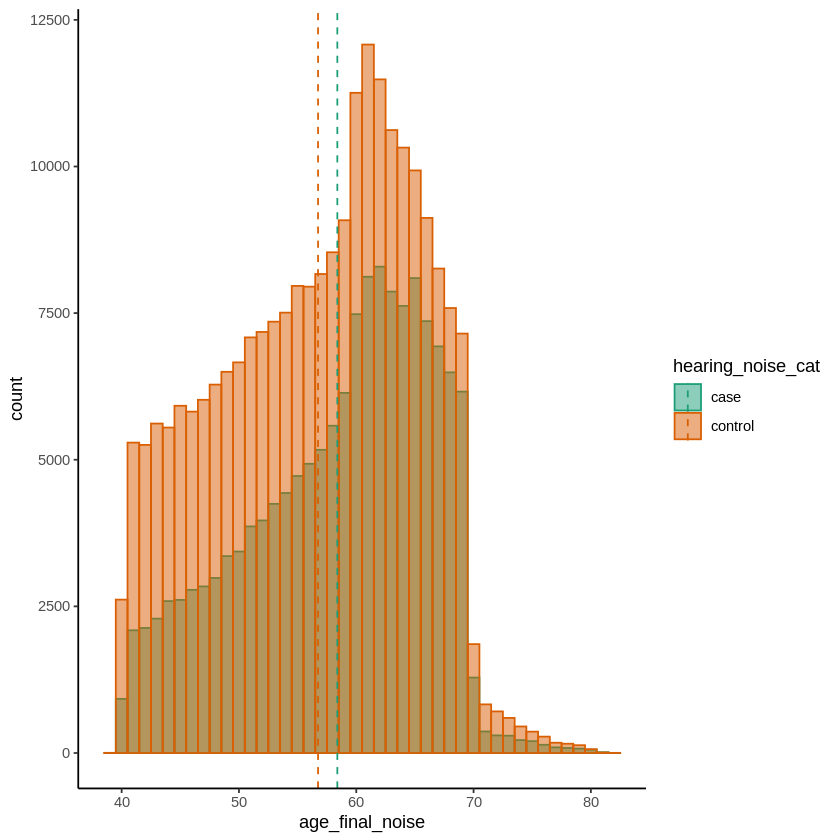

In [126]:
ggplot(f.2257_pheno, aes(x=age_final_noise, fill=hearing_noise_cat, color=hearing_noise_cat)) +
 geom_histogram(binwidth=1, alpha=0.5, position="identity")+
  scale_color_brewer(palette="Dark2")+
  scale_fill_brewer(palette="Dark2") +
  theme(legend.position="top") +
  geom_vline(data=mu5, aes(xintercept=grp.mean, color=hearing_noise_cat),
             linetype="dashed") +
  theme_classic()

In [127]:
length(which((f.2257_pheno$hearing_noise_cat=="control" & f.2257_pheno$age_final_noise <50)))

[1] 54871

In [128]:
length(which((f.2257_pheno$hearing_noise_cat=="case" & f.2257_pheno$age_final_noise <50)))

[1] 24602

In [129]:
mu6 <- ddply(f.2257_pheno, "sex", summarise, grp.mean=mean(age_final_noise))
head(mu6)

,sex,grp.mean
,<fct>,<dbl>
1,male,57.18749
2,female,57.60541


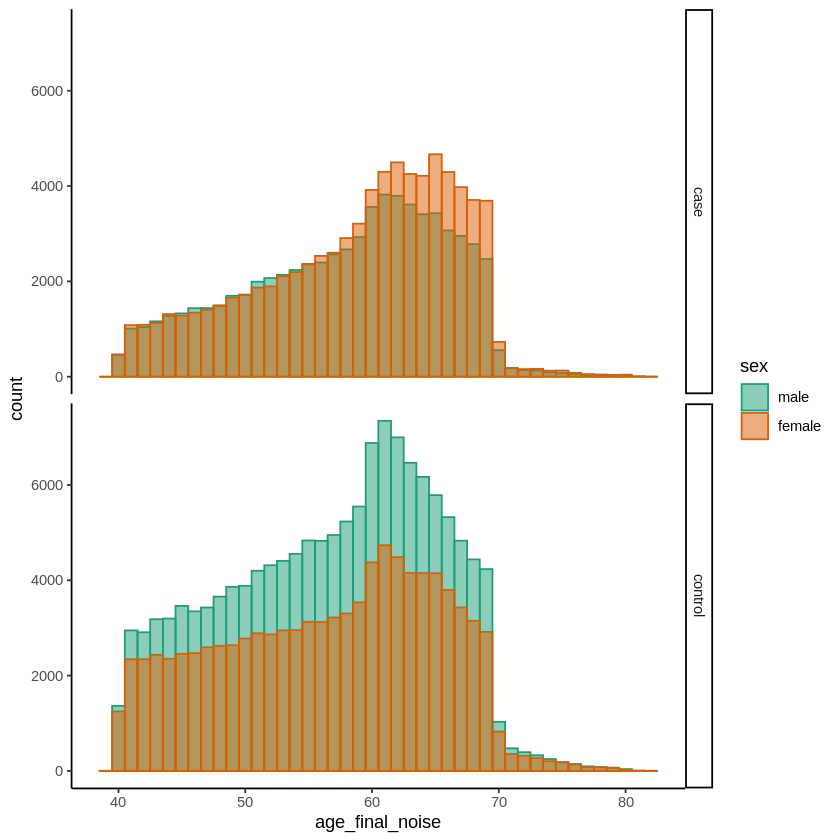

In [130]:
ggplot(f.2257_pheno, aes(x=age_final_noise, fill=sex, color=sex)) +
 geom_histogram(binwidth=1, alpha=0.5, position="identity")+
  scale_color_brewer(palette="Dark2")+
  scale_fill_brewer(palette="Dark2") +
  theme(legend.position="top") +
  theme_classic() +
  facet_grid(hearing_noise_cat ~ .)

## Find out controls positive for f.2247 & f.3393

In [131]:
control_check_2257 <- df_3393_2247_2257 %>%
    filter(hearing_noise_cat==0) %>%
    select(FID, IID, age_final_noise, sex, hearing_noise_cat, starts_with("f.2247"), starts_with("f.3393")) %>%
    mutate(remove_2247 = apply(select(.,starts_with("f.2247")), 1, function(x) length(which(x == "Yes")) > 0),
           remove_3393 = apply(select(.,starts_with("f.3393")), 1, function(x) length(which(x == "Yes")) > 0))
head(control_check_2257)

,FID,IID,age_final_noise,sex,hearing_noise_cat,f.2247.0.0,f.2247.1.0,f.2247.2.0,f.2247.3.0,f.3393.0.0,f.3393.1.0,f.3393.2.0,f.3393.3.0,f.3393.0.0_recode,f.3393.1.0_recode,f.3393.2.0_recode,f.3393.3.0_recode,remove_2247,remove_3393
,<int>,<int>,<int>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<lgl>,<lgl>
1,1000063,1000063,43,0,0,No,NA,NA,NA,No,NA,NA,NA,0,NA,NA,NA,FALSE,FALSE
2,1000078,1000078,60,1,0,No,No,No,NA,NA,No,No,NA,NA,0,0,NA,FALSE,FALSE
3,1000081,1000081,67,0,0,No,NA,NA,NA,No,NA,NA,NA,0,NA,NA,NA,FALSE,FALSE
4,1000090,1000090,64,1,0,Yes,NA,NA,NA,No,NA,NA,NA,0,NA,NA,NA,TRUE,FALSE
5,1000129,1000129,62,0,0,No,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,FALSE,FALSE
6,1000137,1000137,46,1,0,No,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,FALSE,FALSE


In [132]:
length(which(control_check_2257$remove_2247==TRUE)) #controls that replied yes to f.2247
length(which(control_check_2257$remove_3393==TRUE)) #controls that replied yes to f.3393
length(which(control_check_2257$remove_2247==TRUE & control_check_2257$remove_3393==TRUE)) # controls that replied yes to both
length(which(control_check_2257$remove_2247==TRUE | control_check_2257$remove_3393==TRUE)) # controls that replied yes to either

[1] 15102

[1] 539

[1] 478

[1] 15163

In [133]:
#write.table(f.2257_pheno, '200828_UKBB_Hearing_background_noise_f2257', quote = FALSE, row.names = FALSE)
write.table(f.2257_pheno, '120120_UKBB_Hearing_background_noise_f2257_expandedwhite', quote = FALSE, row.names = FALSE)

## Combined phenotype f.2247 and f.2257

In [134]:
hybrid_inconsistent <- df_3393_2247_2257 %>%
 filter(hearing_noise_cat != hearing_diff_new)
head(hybrid_inconsistent)
cat ("There are ",nrow(hybrid_inconsistent),"individuals inconsistent for f.2247 and f.2257")
dim(df_3393_2247_2257)

,IID,FID,ignore1,ignore2,ignore3,ignore4,f.31.0.0,f.34.0.0,f.53.0.0,f.53.1.0,⋯,f.3393.3.0_recode,hearing_aid_cat,age_final_aid,hearing_diff_cat,age_final_diff,hearing_diff_cat_new,hearing_aid_cat_new,hearing_diff_new,hearing_noise_cat,age_final_noise
,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<int>,<fct>,<fct>,⋯,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<int>,<int>
1,1000035,1000035,0,0,1,-9,Male,1944,2007-11-08,NA,⋯,NA,0,63,0,63,control,control,0,1,63
2,1000046,1000046,0,0,2,-9,Female,1946,2008-12-01,NA,⋯,NA,0,73,0,73,control,control,0,1,73
3,1000054,1000054,0,0,2,-9,Female,1942,2007-11-23,NA,⋯,NA,0,65,0,65,control,control,0,1,65
4,1000090,1000090,0,0,2,-9,Female,1945,2010-05-17,NA,⋯,NA,0,64,1,64,case,control,1,0,64
5,1000164,1000164,0,0,2,-9,Female,1958,2009-06-26,NA,⋯,NA,0,51,0,51,control,control,0,1,51
6,1000304,1000304,0,0,2,-9,Female,1951,2008-02-15,NA,⋯,NA,0,56,0,56,control,control,0,1,56


There are  68453 individuals inconsistent for f.2247 and f.2257

[1] 396976   1088

In [135]:
length(which(!is.na(df_3393_2247_2257$hearing_noise_cat) & !is.na(df_3393_2247_2257$hearing_diff_new)))

[1] 368378

In [136]:
length(which(is.na(df_3393_2247_2257$hearing_noise_cat) | is.na(df_3393_2247_2257$hearing_diff_new))) 

[1] 28598

In [137]:
hybrid_consistent <- df_3393_2247_2257 %>%
 filter(hearing_noise_cat == hearing_diff_new)
head(hybrid_consistent)
cat ("There are ",nrow(hybrid_consistent),"individuals consistent for f.2247 and f.2257")

,IID,FID,ignore1,ignore2,ignore3,ignore4,f.31.0.0,f.34.0.0,f.53.0.0,f.53.1.0,⋯,f.3393.3.0_recode,hearing_aid_cat,age_final_aid,hearing_diff_cat,age_final_diff,hearing_diff_cat_new,hearing_aid_cat_new,hearing_diff_new,hearing_noise_cat,age_final_noise
,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<int>,<fct>,<fct>,⋯,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<int>,<int>
1,1000019,1000019,0,0,2,-9,Female,1960,2008-01-24,NA,⋯,NA,0,47,1,47,case,control,1,1,47
2,1000022,1000022,0,0,1,-9,Male,1954,2008-01-22,NA,⋯,NA,0,53,1,53,case,control,1,1,53
3,1000063,1000063,0,0,1,-9,Male,1967,2010-06-26,NA,⋯,NA,0,43,0,43,control,control,0,0,43
4,1000078,1000078,0,0,2,-9,Female,1955,2007-08-20,2012-11-01,⋯,NA,0,60,0,60,control,control,0,0,60
5,1000081,1000081,0,0,1,-9,Male,1942,2009-12-03,NA,⋯,NA,0,67,0,67,control,control,0,0,67
6,1000112,1000112,0,0,1,-9,Male,1949,2008-04-01,NA,⋯,NA,1,68,1,68,case,case,1,1,68


There are  299925 individuals consistent for f.2247 and f.2257

In [138]:
age_consistency <- hybrid_consistent %>%
    select(IID, age_final_diff, age_final_noise)
head(age_consistency)

,IID,age_final_diff,age_final_noise
,<int>,<int>,<int>
1,1000019,47,47
2,1000022,53,53
3,1000063,43,43
4,1000078,60,60
5,1000081,67,67
6,1000112,68,68


In [139]:
# There are inconsistencies for the age between hearing difficulty and background noise
all(age_consistency$age_final_diff == age_consistency$age_final_noise)

[1] FALSE

In [140]:
age_inconsistency <- hybrid_consistent %>%
    filter(age_final_diff != age_final_noise)
head(age_inconsistency)
cat ("There are",nrow(age_inconsistency), "individuals with inconsistent ages for hearing difficulty and background noise")

,IID,FID,ignore1,ignore2,ignore3,ignore4,f.31.0.0,f.34.0.0,f.53.0.0,f.53.1.0,⋯,f.3393.3.0_recode,hearing_aid_cat,age_final_aid,hearing_diff_cat,age_final_diff,hearing_diff_cat_new,hearing_aid_cat_new,hearing_diff_new,hearing_noise_cat,age_final_noise
,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<int>,<fct>,<fct>,⋯,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<int>,<int>
1,1002378,1002378,0,0,1,-9,Male,1950,2008-11-01,NA,⋯,NA,0,68,1,58,case,control,1,1,68
2,1006407,1006407,0,0,2,-9,Female,1949,2008-09-30,NA,⋯,NA,0,65,1,59,case,control,1,1,65
3,1006513,1006513,0,0,2,-9,Female,1955,2010-02-23,NA,⋯,NA,1,59,1,59,case,case,1,1,54
4,1008266,1008266,0,0,1,-9,Male,1949,2008-04-30,NA,⋯,NA,0,69,1,58,case,control,1,1,69
5,1012730,1012730,0,0,1,-9,Male,1947,2010-05-26,NA,⋯,0,0,73,1,70,case,control,1,1,63
6,1015865,1015865,0,0,2,-9,Female,1948,2010-04-27,NA,⋯,NA,0,71,1,71,case,control,1,1,62


There are 3608 individuals with inconsistent ages for hearing difficulty and background noise

In [141]:
age_inconsistency_cases <- hybrid_consistent %>%
    filter(hearing_noise_cat == 1 &  hearing_diff_new ==1) %>%
    filter(age_final_diff != age_final_noise) %>%
    select(FID, IID, sex, hearing_diff_new, hearing_noise_cat, age_final_diff, age_final_noise)
head(age_inconsistency_cases)
cat ("There are",nrow(age_inconsistency_cases), "cases with inconsistent ages for hearing difficulty and background noise")

,FID,IID,sex,hearing_diff_new,hearing_noise_cat,age_final_diff,age_final_noise
,<int>,<int>,<fct>,<fct>,<int>,<int>,<int>
1,1002378,1002378,0,1,1,58,68
2,1006407,1006407,1,1,1,59,65
3,1006513,1006513,1,1,1,59,54
4,1008266,1008266,0,1,1,58,69
5,1012730,1012730,0,1,1,70,63
6,1015865,1015865,1,1,1,71,62


There are 3600 cases with inconsistent ages for hearing difficulty and background noise

In [142]:
age_inconsistency_controls <- hybrid_consistent %>%
    filter(hearing_noise_cat == 0 &  hearing_diff_new == 0) %>%
    filter(age_final_diff != age_final_noise) %>%
    select(FID, IID, sex, hearing_diff_new, hearing_noise_cat, age_final_diff, age_final_noise)
head(age_inconsistency_controls)
cat ("There are",nrow(age_inconsistency_controls), "controls with inconsistent ages for hearing difficulty and background noise")

,FID,IID,sex,hearing_diff_new,hearing_noise_cat,age_final_diff,age_final_noise
,<int>,<int>,<fct>,<fct>,<int>,<int>,<int>
1,1469184,1469184,0,0,0,70,63
2,1740024,1740024,0,0,0,41,46
3,2505170,2505170,0,0,0,56,61
4,2876630,2876630,1,0,0,65,75
5,3618107,3618107,0,0,0,59,69
6,3854162,3854162,0,0,0,50,48


There are 8 controls with inconsistent ages for hearing difficulty and background noise

In [143]:
#get the minimum age for 2247 and 2257 for cases
age_inconsistency_cases <- transform(age_inconsistency_cases, age_diff_noise = pmin(age_final_noise, age_final_diff))
head(age_inconsistency_cases)

,FID,IID,sex,hearing_diff_new,hearing_noise_cat,age_final_diff,age_final_noise,age_diff_noise
,<int>,<int>,<fct>,<fct>,<int>,<int>,<int>,<int>
1,1002378,1002378,0,1,1,58,68,58
2,1006407,1006407,1,1,1,59,65,59
3,1006513,1006513,1,1,1,59,54,54
4,1008266,1008266,0,1,1,58,69,58
5,1012730,1012730,0,1,1,70,63,63
6,1015865,1015865,1,1,1,71,62,62


In [144]:
#get the maximun age for 2247 and 2257 for controls
age_inconsistency_controls <- transform(age_inconsistency_controls, age_diff_noise = pmax(age_final_noise, age_final_diff))
head(age_inconsistency_controls,10)

,FID,IID,sex,hearing_diff_new,hearing_noise_cat,age_final_diff,age_final_noise,age_diff_noise
,<int>,<int>,<fct>,<fct>,<int>,<int>,<int>,<int>
1,1469184,1469184,0,0,0,70,63,70
2,1740024,1740024,0,0,0,41,46,46
3,2505170,2505170,0,0,0,56,61,61
4,2876630,2876630,1,0,0,65,75,75
5,3618107,3618107,0,0,0,59,69,69
6,3854162,3854162,0,0,0,50,48,50
7,4366635,4366635,0,0,0,57,46,57
8,5668953,5668953,1,0,0,74,69,74


In [145]:
age_solved <- rbind(age_inconsistency_cases, age_inconsistency_controls)
nrow(age_solved)
head(age_solved)

[1] 3608

,FID,IID,sex,hearing_diff_new,hearing_noise_cat,age_final_diff,age_final_noise,age_diff_noise
,<int>,<int>,<fct>,<fct>,<int>,<int>,<int>,<int>
1,1002378,1002378,0,1,1,58,68,58
2,1006407,1006407,1,1,1,59,65,59
3,1006513,1006513,1,1,1,59,54,54
4,1008266,1008266,0,1,1,58,69,58
5,1012730,1012730,0,1,1,70,63,63
6,1015865,1015865,1,1,1,71,62,62


In [146]:
hybrid_age_consistent <- hybrid_consistent  %>%
    filter(age_final_diff == age_final_noise) %>%
    select(FID, IID, sex, hearing_diff_new, hearing_noise_cat, age_final_diff, age_final_noise) %>%
    mutate(age_diff_noise = age_final_diff) 
head(hybrid_age_consistent)
cat ("There are ",nrow(hybrid_age_consistent),"individuals consistent for age and phenotype for f.2247 and f.2257")

,FID,IID,sex,hearing_diff_new,hearing_noise_cat,age_final_diff,age_final_noise,age_diff_noise
,<int>,<int>,<fct>,<fct>,<int>,<int>,<int>,<int>
1,1000019,1000019,1,1,1,47,47,47
2,1000022,1000022,0,1,1,53,53,53
3,1000063,1000063,0,0,0,43,43,43
4,1000078,1000078,1,0,0,60,60,60
5,1000081,1000081,0,0,0,67,67,67
6,1000112,1000112,0,1,1,68,68,68


There are  296317 individuals consistent for age and phenotype for f.2247 and f.2257

In [147]:
f2247_f2257_pheno <- rbind (hybrid_age_consistent, age_solved)
head(f2247_f2257_pheno)
nrow(f2247_f2257_pheno)

,FID,IID,sex,hearing_diff_new,hearing_noise_cat,age_final_diff,age_final_noise,age_diff_noise
,<int>,<int>,<fct>,<fct>,<int>,<int>,<int>,<int>
1,1000019,1000019,1,1,1,47,47,47
2,1000022,1000022,0,1,1,53,53,53
3,1000063,1000063,0,0,0,43,43,43
4,1000078,1000078,1,0,0,60,60,60
5,1000081,1000081,0,0,0,67,67,67
6,1000112,1000112,0,1,1,68,68,68


[1] 299925

In [148]:
names(f2247_f2257_pheno)[names(f2247_f2257_pheno) == 'hearing_diff_new'] <- 'f2247_f2257'
names(f2247_f2257_pheno)[names(f2247_f2257_pheno) == 'age_diff_noise'] <- 'age_combined'
f2247_f2257_pheno <- f2247_f2257_pheno %>%
 select(FID, IID, age_combined, sex, f2247_f2257 )
head(f2247_f2257_pheno)

,FID,IID,age_combined,sex,f2247_f2257
,<int>,<int>,<int>,<fct>,<fct>
1,1000019,1000019,47,1,1
2,1000022,1000022,53,0,1
3,1000063,1000063,43,0,0
4,1000078,1000078,60,1,0
5,1000081,1000081,67,0,0
6,1000112,1000112,68,0,1


In [149]:
cases_combined <- f2247_f2257_pheno %>%
    filter(f2247_f2257 == 1)
nrow(cases_combined)

[1] 84951

In [150]:
controls_combined <- f2247_f2257_pheno %>%
    filter(f2247_f2257 == 0)
nrow(controls_combined)

[1] 214974

## Merge with complete database

In [151]:
#Merge with complete database keep the all the rows from original db
df_3393_2247_2257_combined = merge(x = df_3393_2247_2257, y = f2247_f2257_pheno [,c("IID","f2247_f2257","age_combined")],by="IID", all.x=TRUE)
dim(df_3393_2247_2257_combined)
head(df_3393_2247_2257_combined)

[1] 396976   1090

,IID,FID,ignore1,ignore2,ignore3,ignore4,f.31.0.0,f.34.0.0,f.53.0.0,f.53.1.0,⋯,age_final_aid,hearing_diff_cat,age_final_diff,hearing_diff_cat_new,hearing_aid_cat_new,hearing_diff_new,hearing_noise_cat,age_final_noise,f2247_f2257,age_combined
,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<int>,<fct>,<fct>,⋯,<int>,<int>,<int>,<fct>,<fct>,<fct>,<int>,<int>,<fct>,<int>
1,1000019,1000019,0,0,2,-9,Female,1960,2008-01-24,NA,⋯,47,1,47,case,control,1,1,47,1,47
2,1000022,1000022,0,0,1,-9,Male,1954,2008-01-22,NA,⋯,53,1,53,case,control,1,1,53,1,53
3,1000035,1000035,0,0,1,-9,Male,1944,2007-11-08,NA,⋯,63,0,63,control,control,0,1,63,NA,NA
4,1000046,1000046,0,0,2,-9,Female,1946,2008-12-01,NA,⋯,73,0,73,control,control,0,1,73,NA,NA
5,1000054,1000054,0,0,2,-9,Female,1942,2007-11-23,NA,⋯,65,0,65,control,control,0,1,65,NA,NA
6,1000063,1000063,0,0,1,-9,Male,1967,2010-06-26,NA,⋯,43,0,43,control,control,0,0,43,0,43


## Histogram for age of cases and controls

In [152]:
f2247_f2257_pheno <- f2247_f2257_pheno %>%
 select(FID, IID, age_combined, sex, f2247_f2257 )%>%
 mutate(f2247_f2257=recode_factor(f2247_f2257, `1`="case",`0`="control"),
           sex=recode_factor(sex, `1`="male", `0`="female" ))
head(f2247_f2257_pheno)
dim(f2247_f2257_pheno)

,FID,IID,age_combined,sex,f2247_f2257
,<int>,<int>,<int>,<fct>,<fct>
1,1000019,1000019,47,male,case
2,1000022,1000022,53,female,case
3,1000063,1000063,43,female,control
4,1000078,1000078,60,male,control
5,1000081,1000081,67,female,control
6,1000112,1000112,68,female,case


[1] 299925      5

In [153]:
mu7 <- ddply(f2247_f2257_pheno, "f2247_f2257", summarise, grp.mean=mean(age_combined))
head(mu7)

,f2247_f2257,grp.mean
,<fct>,<dbl>
1,case,59.28083
2,control,56.58007


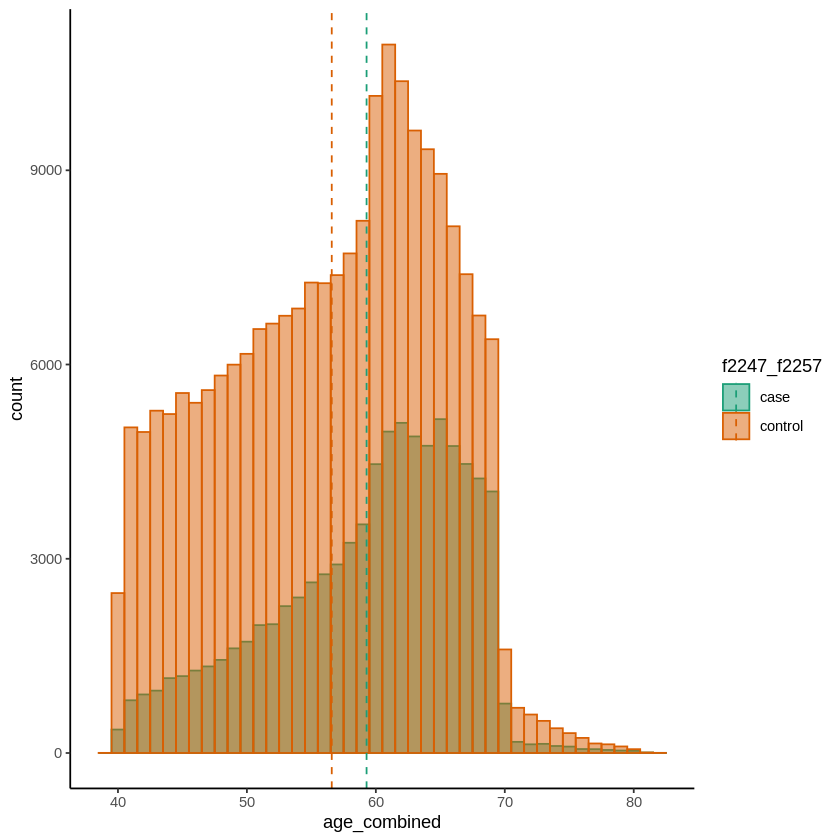

In [154]:
ggplot(f2247_f2257_pheno, aes(x=age_combined, fill=f2247_f2257, color=f2247_f2257)) +
 geom_histogram(binwidth=1, alpha=0.5, position="identity")+
  scale_color_brewer(palette="Dark2")+
  scale_fill_brewer(palette="Dark2") +
  theme(legend.position="top") +
  geom_vline(data=mu7, aes(xintercept=grp.mean, color=f2247_f2257),
             linetype="dashed") +
  theme_classic()

In [155]:
length(which((f2247_f2257_pheno$f2247_f2257=="control" & f2247_f2257_pheno$age_combined <50)))

[1] 51383

In [156]:
length(which((f2247_f2257_pheno$f2247_f2257=="case" & f2247_f2257_pheno$age_combined <50)))

[1] 11050

In [157]:
mu8 <- ddply(f2247_f2257_pheno, "sex", summarise, grp.mean=mean(age_combined))
head(mu8)

,sex,grp.mean
,<fct>,<dbl>
1,male,57.14077
2,female,57.59831


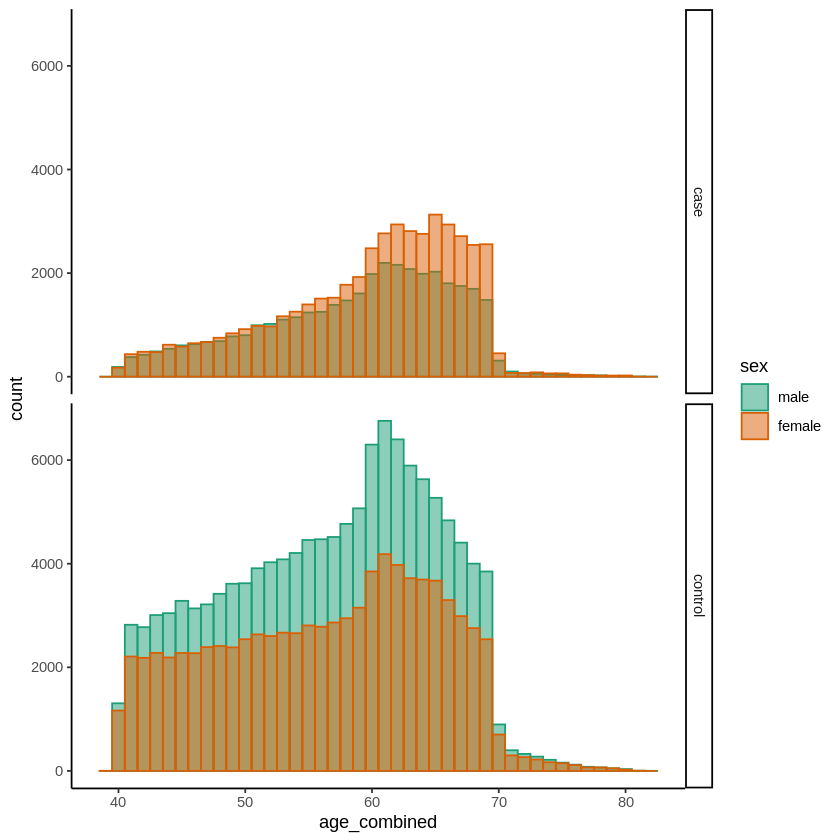

In [158]:
ggplot(f2247_f2257_pheno, aes(x=age_combined, fill=sex, color=sex)) +
 geom_histogram(binwidth=1, alpha=0.5, position="identity")+
  scale_color_brewer(palette="Dark2")+
  scale_fill_brewer(palette="Dark2") +
  theme(legend.position="top") +
  theme_classic() +
  facet_grid(f2247_f2257 ~ .)

In [159]:
#Summary age of cases and controls
tapply(f2247_f2257_pheno$age_combined,  f2247_f2257_pheno$f2247_f2257, summary)

$case
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  40.00   54.00   61.00   59.28   65.00   82.00 

$control
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  39.00   50.00   58.00   56.58   63.00   82.00 


## Find out controls positive for  f.3393

In [160]:
control_check_combined <- df_3393_2247_2257_combined %>%
    filter(f2247_f2257==0) %>%
    select(FID, IID, age_combined, sex, f2247_f2257, starts_with("f.3393")) %>%
    mutate(remove_3393 = apply(select(.,starts_with("f.3393")), 1, function(x) length(which(x == "Yes")) > 0))
head(control_check_combined)
dim(control_check_combined)

,FID,IID,age_combined,sex,f2247_f2257,f.3393.0.0,f.3393.1.0,f.3393.2.0,f.3393.3.0,f.3393.0.0_recode,f.3393.1.0_recode,f.3393.2.0_recode,f.3393.3.0_recode,remove_3393
,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<lgl>
1,1000063,1000063,43,0,0,No,NA,NA,NA,0,NA,NA,NA,FALSE
2,1000078,1000078,60,1,0,NA,No,No,NA,NA,0,0,NA,FALSE
3,1000081,1000081,67,0,0,No,NA,NA,NA,0,NA,NA,NA,FALSE
4,1000129,1000129,62,0,0,NA,NA,NA,NA,NA,NA,NA,NA,FALSE
5,1000137,1000137,46,1,0,NA,NA,NA,NA,NA,NA,NA,NA,FALSE
6,1000141,1000141,49,1,0,No,NA,NA,NA,0,NA,NA,NA,FALSE


[1] 214974     14

In [161]:
length(which(control_check_combined$remove_3393==TRUE)) #controls that replied yes to f.3393

[1] 1

In [162]:
#write.table(f2247_f2257_pheno, '200828_UKBB_f2247_f2257', quote = FALSE, row.names = FALSE)
write.table(f2247_f2257_pheno, '120120_UKBB_f2247_f2257_expandedwhite', quote = FALSE, row.names = FALSE)